# Машинное обучение, ФКН ВШЭ

## Практическое задание 4. Классификация

### Общая информация
Дата выдачи: 16.11.2024

Мягкий дедлайн: 28.11.2024

Жесткий дедлайн: 02.12.2024

### О задании

В этом задании вы:
- ознакомитесь с тем, что происходит "внутри" метода опорных векторов и логистической регрессии
- познакомитесь с калибровкой вероятности
- изучите методы трансформации переменных и методы отбора признаков
- попробуете оценить экономический эффект модели

----

#### Самостоятельная оценка результатов

Для удобства проверки, исходя из набора решенных задач, посчитайте свою максимальную оценку.

**Оценка**: 10,71

### Оценивание и штрафы

Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

### Формат сдачи

Для сдачи задания переименуйте получившийся файл *.ipynb в соответствии со следующим форматом: homework-practice-04-linclass-__Username__.ipynb, где Username — ваша фамилия и имя на латинице именно в таком порядке (например, homework-practice-04-linclass-__IvanovIvan__.ipynb).

# Часть 1. SVM, LR и калибровка вероятностей (2 балла + 0.5 бонус)

In [2]:
import numpy as np
import pandas as pd
# import polars as pl
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
# pl.Config().set_tbl_rows(100)
# pl.Config().set_tbl_cols(100)

#### __Задание 1.1  Сравнение методов__ (0.5 балла)



Сгенерируем синтетические данные.

In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [4]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

**Вопрос:** решаем задачу бинарной классификации, но y\_random содержит какие-то дробные числа, а не 0/1. Почему?



**Ответ**: # your answer here
здесь мы получаем вероятность того, что объект принадлежит положительному классу

*Ниже приведен **пример** работы* со встроенными функциями `sklearn` для отрисовки ROC и PR кривых, сохранения метрик. Пайплайн можно изменять как вам удобно.

In [5]:
from sklearn.metrics import average_precision_score

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000


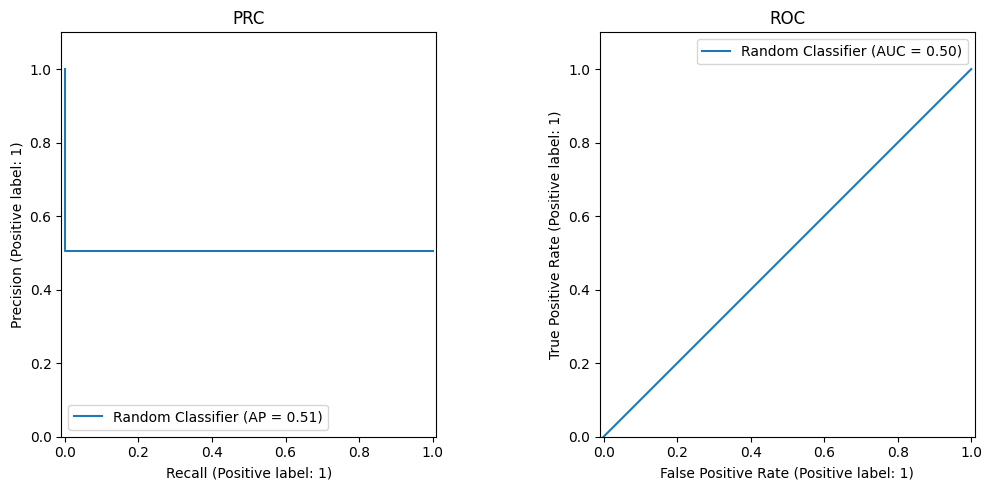

In [6]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 2, figsize=(11, 5))

    print(classifier_name, 'metrics')
    PrecisionRecallDisplay.from_predictions(y_true, y_pred, ax=ax[0], name=classifier_name)
    print('AUC-PR: %.4f' % average_precision_score(y_true, y_pred))
    ax[0].set_title("PRC")
    ax[0].set_ylim(0, 1.1)

    RocCurveDisplay.from_predictions(y_true, y_pred, ax=ax[1], name=classifier_name)
    print('AUC-ROC: %.4f' % roc_auc_score(y_true, y_pred))
    ax[1].set_title("ROC")
    ax[1].set_ylim(0, 1.1)

    plt.tight_layout()
    plt.legend()


depict_pr_roc(y_test, y_random, 'Random Classifier')

In [7]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(
    columns=['auc_pr', 'roc_auc_score', 'reg_const']
)
precision, recall, _ = precision_recall_curve(y_test, y_random)
# добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      average_precision_score(y_test, y_random),
      roc_auc_score(y_test, y_random),
      0,
]

# по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.5,0.0


__Support Vector Machine (Linear Kernel)__

Обучите метод опорных векторов.

Подберите параметр регуляризации `C` с точки зрения AUC-PR (можете воспользоваться кросс-валидацией или отделить валидационную выборку от обучающей).


In [8]:
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.metrics import make_scorer, precision_recall_curve, average_precision_score
from sklearn.model_selection import GridSearchCV, train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=42)

c_space = {'C': np.logspace(-10, 10, 20)}
def auc_pr_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return average_precision_score(y_true, y_pred)
auc_pr_scorer = make_scorer(auc_pr_score, greater_is_better=True, needs_proba=False)

model = LinearSVC(dual="auto", random_state=42)

grid_search = GridSearchCV(model, c_space, cv=5, scoring=auc_pr_scorer)
grid_search.fit(X_train, y_train)

best_c_SVM = grid_search.best_params_['C']
print("Best C =", best_c_SVM)
print("Best score =", grid_search.best_score_)


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best C = 0.00020691380811147902
Best score = 0.7256965787820112


  На тестовой части:
  - постройте ROC и PR кривые,
  - посчитайте AUC-ROC, AUC-PR

SVM metrics
AUC-PR: 0.8274
AUC-ROC: 0.8450


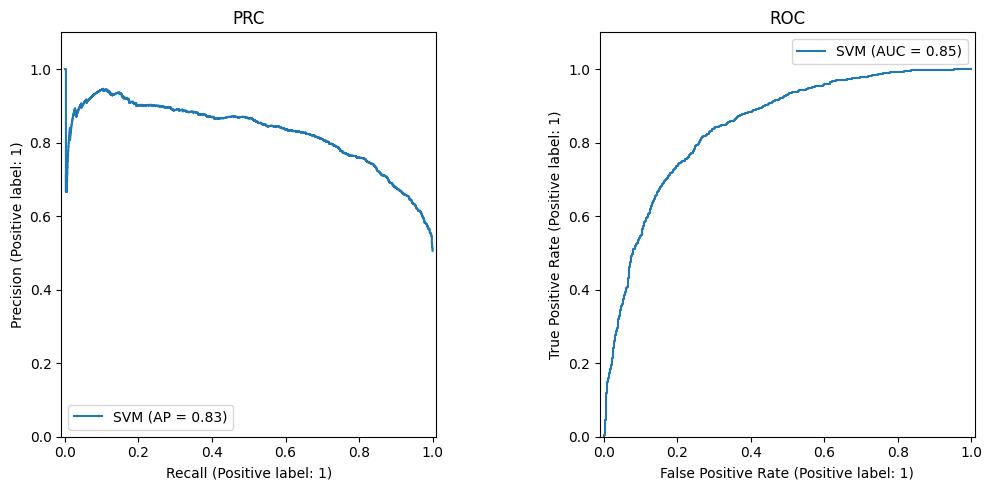

In [9]:
# your code here
lin_clf = LinearSVC(dual="auto", C=best_c_SVM)
lin_clf.fit(X_train, y_train)
y_pred_svm = lin_clf.decision_function(X_test)
y_prob = (y_pred_svm - y_pred_svm.min()) / (y_pred_svm.max() -y_pred_svm.min())
depict_pr_roc(y_test, y_prob, "SVM")


Проанализируйте, как себя ведут обе кривые:
- Что происходит при увеличении порога? Как бы вы это проинтерпретировали?
- Монотонные ли кривые? Как вы это объясните?

PR-кривая:

При увеличении порога precision нерезко растет, так как меньше ложных положительных
Однако при этом снижаться recall, так как часть истинно положительных примеров начинает классифицироваться как отрицательные.

ROC-кривая:

TPR уменьшается с ростом порога, потому что модель может пропустить некоторые положительные примеры.
FPR тоже уменьшается, потому что модель будет реже ошибаться, классифицируя отрицательные примеры как положительные. При низком пороге (например, 0.1 или 0.2) модель считает большинство объектов положительными, что приводит к высокой TPR, но также к высокой FPR (много отрицательных объектов классифицируются как положительные).
При высоком пороге модель требует высокой уверенности в классификации, и TPR и FPR будут низкими.


PR - немонотонная, так как Precision может не монотонно изменяться при изменении порога. Это происходит потому, что на определённых порогах, несмотря на увеличение Recall, точность может снизиться из-за роста FP.

ROC-кривая монотонно возрастает, так как TPR и FPR рассчитываются как накопленные значения при изменении порога.

Здесь графики с порогами

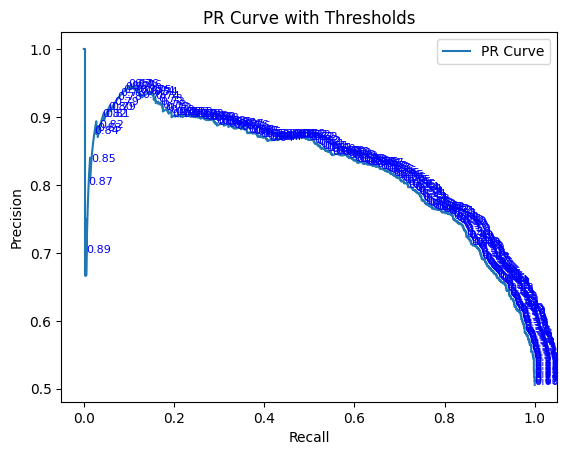

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve
precision, recall, thresholds = precision_recall_curve(y_test, y_prob)
plt.plot(recall, precision, label="PR Curve")
for i, threshold in enumerate(thresholds):
    if i % 10 == 0:
        plt.text(recall[i], precision[i], f'{threshold:.2f}', fontsize=8, color='blue')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('PR Curve with Thresholds')
plt.legend()
plt.show()

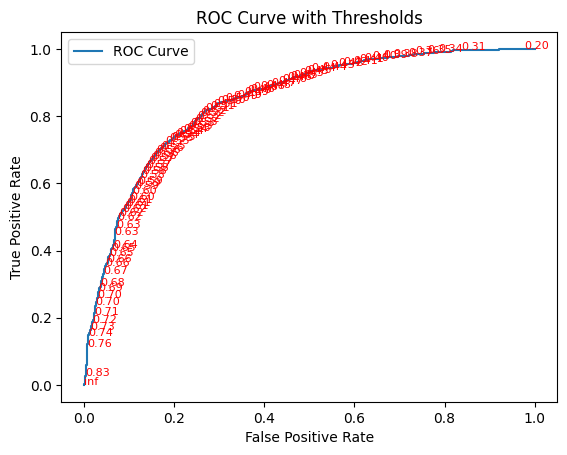

In [11]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
plt.plot(fpr, tpr, label="ROC Curve")
for i, threshold in enumerate(thresholds):
    if i % 10 == 0:
        plt.text(fpr[i], tpr[i], f'{threshold:.2f}', fontsize=8, color='red')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve with Thresholds')
plt.legend()
plt.show()

Сравните AUC-ROC и AUC-PR для вашей модели с этими же метриками для случайного классификатора.

In [12]:
# your code here
avg_precision = average_precision_score(y_test, y_prob)
roc_auc = roc_auc_score(y_test,  y_prob)
df_metrics.loc['SVM'] = [
    avg_precision,
    roc_auc,
    best_c_SVM
]
df_metrics


,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVM,0.827414,0.845007,0.000207


__Logistic Regression__


Аналогичное задание для логистической регрессии с L2 регуляризатором:


*   подберите гиперпараметр C, используя метрику AUC-PR
*   нарисуйте ROC, PR кривые для тестовой части
*   выведите метрики для тестовых данных и сравните их с результатами случайного классификатора



In [13]:
from sklearn.linear_model import LogisticRegression

# your code here
c_space = {'C': np.logspace(-10, 10, 20)}
def auc_pr_score(y_true, y_pred):
    precision, recall, _ = precision_recall_curve(y_true, y_pred)
    return average_precision_score(y_true, y_pred)
auc_pr_scorer = make_scorer(auc_pr_score, greater_is_better=True, needs_proba=False)

model = LogisticRegression()

grid_search = GridSearchCV(model, c_space, cv=5, scoring=auc_pr_scorer)
grid_search.fit(X_train, y_train)

best_c_LogReg = grid_search.best_params_['C']
print("Best C =", best_c_LogReg)
print("Best score =", grid_search.best_score_)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best C = 0.002335721469090121
Best score = 0.7258635369021806


Logistic Regression metrics
AUC-PR: 0.8311
AUC-ROC: 0.8459


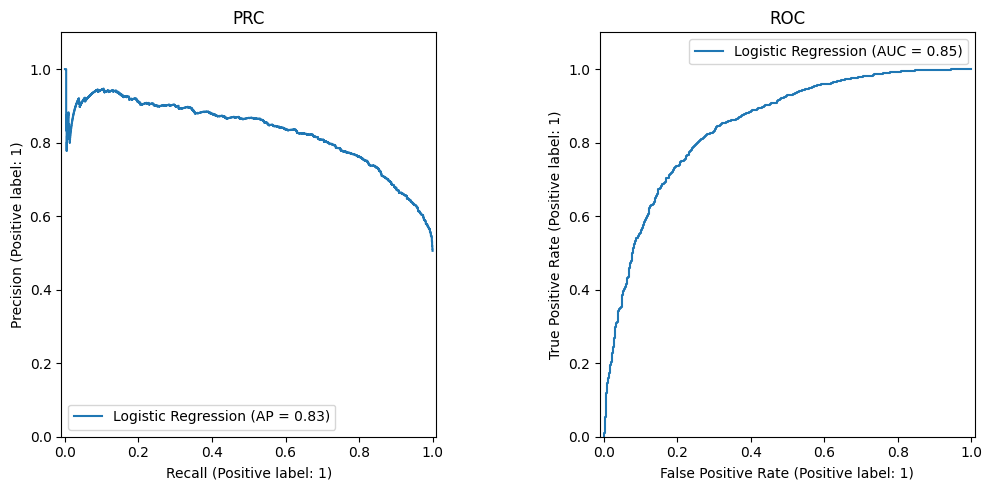

In [14]:
lin_clf = LogisticRegression(penalty='l2', dual=False, C = best_c_LogReg, max_iter=1000)
lin_clf.fit(X_train, y_train)
y_pred_log = lin_clf.predict_proba(X_test)
depict_pr_roc(y_test, y_pred_log[:, 1], "Logistic Regression")

Нарисуйте ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

Random Classifier metrics
AUC-PR: 0.5057
AUC-ROC: 0.5000
SVM metrics
AUC-PR: 0.8274
AUC-ROC: 0.8450
Logistic Regression metrics
AUC-PR: 0.8311
AUC-ROC: 0.8459


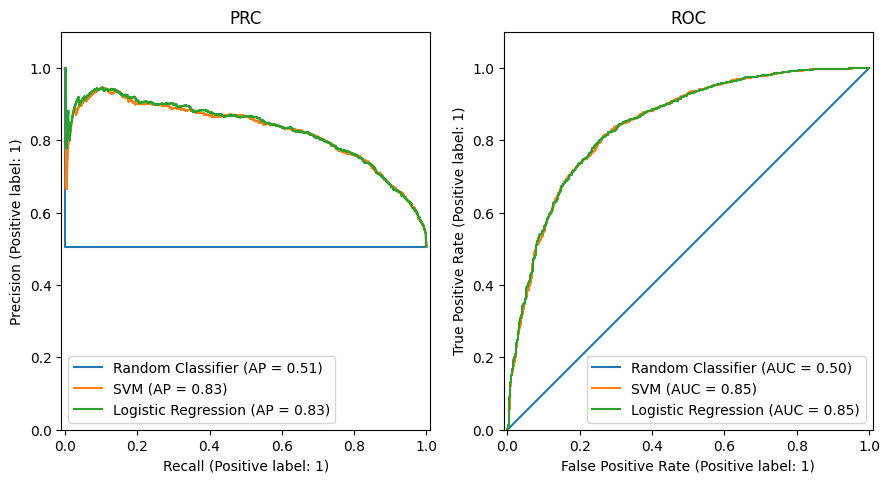

In [15]:
fig, ax = plt.subplots(1, 2, figsize = (9, 6))
depict_pr_roc(y_test, y_random, "Random Classifier", ax = ax)
depict_pr_roc(y_test, y_pred_svm, "SVM", ax = ax)
depict_pr_roc(y_test, y_pred_log[:, 1], "Logistic Regression", ax= ax)

**Вопрос:** Сравните результаты LR и SVM с точки зрения всех вычисленных критериев качества, объясните различия (если они есть).



In [16]:
avg_precision = average_precision_score(y_test, y_prob)
roc_auc = roc_auc_score(y_test,  y_pred_log[:, 1])
df_metrics.loc['LogisticRegression'] = [
    avg_precision,
    roc_auc,
    best_c_LogReg
]
df_metrics

,auc_pr,roc_auc_score,reg_const
Random Classifier,0.505667,0.500000,0.000000
SVM,0.827414,0.845007,0.000207
LogisticRegression,0.827414,0.845882,0.002336


**Ответ:** # your answer here

Logistic Regression имеет немного более высокий ROC AUC (0.845882) по сравнению с SVM (0.845007), хотя разница минимальна.

 Logistic Regression имеет более высокий параметр C (0.002336). LR менее строго штрафует за слишком сложные модели, чем SVM.

#### __Задание 1.2. Визуализация в подходах SVM, LR__ (0.5 балла)



В названии метода опорных векторов присутствуют некоторые "опорные векторы". По сути, это объекты из обучающей выборки, которые задали положение разделяющей гиперплоскости.

* Сгенерируйте синтетические данные с помощью `make_classification` __с 2 признаками__, обучите на нём метод опорных векторов. Не забудьте зафиксировать seed для воспроизводимости

* Визуализируйте разделяющую прямую, все объекты и выделите опорные векторы. Ниже есть шаблоны, можете воспользоваться ими, либо написать своё

In [17]:
# your code here
X, y = make_classification(
    n_samples=10000, n_features=2, n_informative=2, n_redundant=0, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [18]:
from sklearn.svm import SVC
model = SVC(C=best_c_SVM, kernel='linear', gamma='auto', random_state=42)
model.fit(X_train, y_train)

SVC(C=0.00020691380811147902, gamma='auto', kernel='linear', random_state=42)

SVM metrics
AUC-PR: 0.9257
AUC-ROC: 0.9397


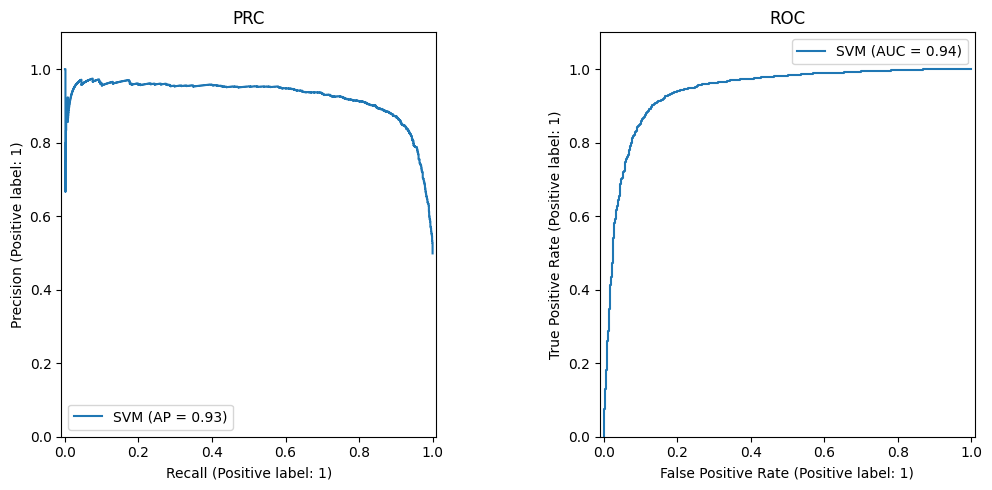

In [19]:
y_pred_svm_new = model.decision_function(X_test)
y_prob = (y_pred_svm_new - y_pred_svm_new.min()) / (y_pred_svm_new.max() - y_pred_svm_new.min())
depict_pr_roc(y_test, y_prob, "SVM")

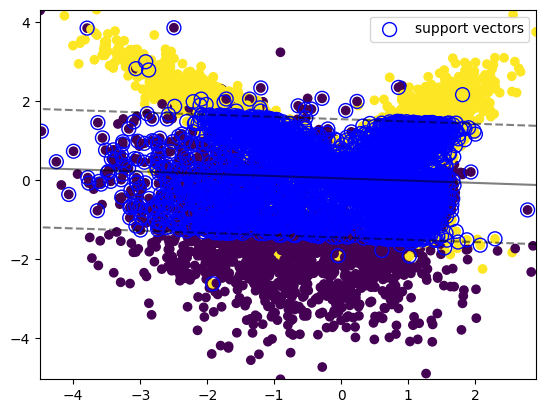

In [20]:
def plot_svm_2D(X, y, model,  plot_support=True):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 30)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 30)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки разделяющей прямой
    Z = model.decision_function(xy).reshape(XX.shape)

    plt.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])

    # Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c = y
    )

    # Отрисовали опорные векторы
    if plot_support:
        plt.scatter(
            model.support_vectors_[:, 0],
            model.support_vectors_[:, 1],
            label='support vectors',
            s=100,
            linewidth=1,
            edgecolor="blue",
            facecolors='none'
        )

    plt.legend()

plot_svm_2D(X, y, model)

**Вопрос:** какие объекты выделяются как "опорные"?



**Ответ:** # your answer here
support vectors лежат на границе разделяющей гиперплоскости или непосредственно около нее, то есть расстояние от которых до разделяющей гиперплоскости не превышает отступ

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$. Попробуйте нарисовать это распределение на плоскости, не забудьте отметить на ней все объекты.

In [21]:
model = LogisticRegression(C=best_c_LogReg)
model.fit(X_train, y_train)

LogisticRegression(C=0.002335721469090121)

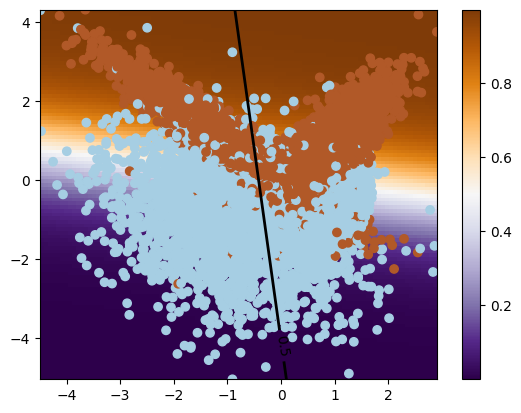

In [22]:
def plot_logreg_2D(X, y, model):

    # создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    # Ответы модели для сетки для отрисовки распределения
    Z = model.predict_proba(xy)[:, 1]
    Z = Z.reshape((xx.shape[0], -1)).T

    image = plt.imshow(
        Z,
        interpolation='nearest',
        extent=(xx.min(), xx.max(), yy.min(), yy.max()),
        aspect='auto',
        origin='lower',
        cmap=plt.cm.PuOr_r
    )
    contour = plt.contour(XX, YY, Z, levels=[0.5], colors='black', linestyles=['-'], linewidths=2)
    plt.clabel(contour, fmt='0.5', inline=True, fontsize=10)
    #Отрисовали выборку
    plt.scatter(
        X[:, 0], X[:, 1], c=y,
        cmap=plt.cm.Paired
    )



    plt.colorbar(image)

plot_logreg_2D(X, y, model)

**Вопрос:** Как на картинке визуализирована область, где модель не уверена ($p(y=+1|x) = 0.5$)? Как это обосновать теоритечески?



**Ответ:** # your answer here
Область неопределенности — это сама разделяющая гиперплоскость и её окрестности.

Если объект близко к гиперплоскости, скалярное произведение весов и признаков мало, а вероятность предсказания приближается к
0.5
0.5 — модель не уверена.
Если объект далеко от гиперплоскости, скалярное произведение велико по модулю, и вероятность ближе к
0
0 или
1
1 — модель уверена.

#### __Задание 2. Калибровка вероятностей__ (1 балл)



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хорошо ли они оценивают вероятность?

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной криовой используем следующий алгоритм:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

Ниже приведена функция, которая должна рисовать такие кривые. В ней допущено две ошибки — найдите и исправьте их.

In [23]:
def plot_calibration_curve(y_test, preds):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        if np.sum((preds >= l) & (preds < r)) > 0:
            bin_real_ratios.append(np.mean(y_test[(preds >= l) & (preds < r)] == 1))
        else:
            bin_real_ratios.append(0)
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.ylim([-0.05, 1.05])
    plt.grid()

Сгенерируйте синтетические данные аналогично использованным в самом первом задании. Постройте калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов (не забудьте перевести его предсказания в $[0;1]$).

Отрисуйте калибровочную кривую идеально откалиброванной модели (диагональ)

In [24]:
from sklearn.preprocessing import normalize
from scipy.special import expit


X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42
)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

logistic_clf = LogisticRegression(penalty='l2', C=best_c_LogReg).fit(X_train, y_train)
y_log_proba = logistic_clf.predict_proba(X_test)[:,1]


<Figure size 800x800 with 0 Axes>

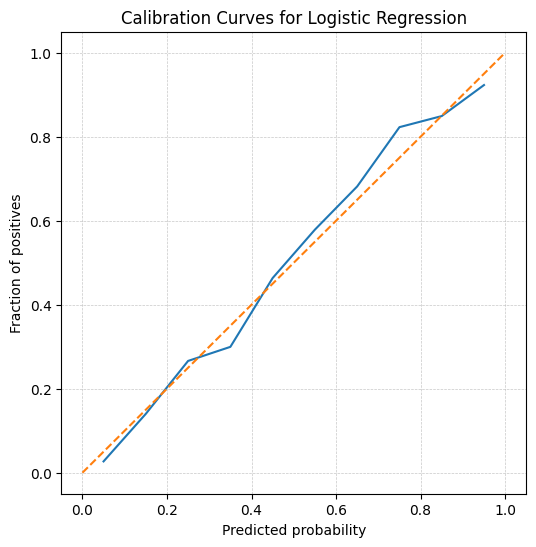

In [25]:
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test, y_log_proba)
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title("Calibration Curves for Logistic Regression")
plt.plot([0, 1], [0, 1], '--')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

In [26]:
svm_clf = SVC(C=best_c_SVM, kernel='linear', probability=True).fit(X_train, y_train)
svm_decision = svm_clf.decision_function(X_test)
y_pred_svm = svm_clf.predict_proba(X_test)[:, 1]
true_svm_decision = (svm_decision - svm_decision.min()) / (svm_decision.max() - svm_decision.min())

<Figure size 800x800 with 0 Axes>

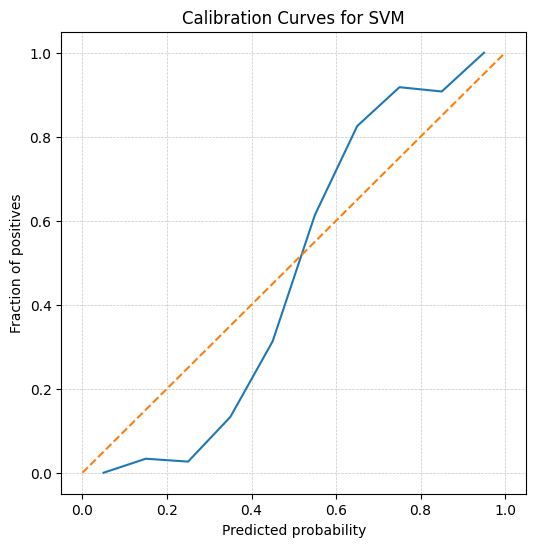

In [27]:
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test,true_svm_decision)
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title("Calibration Curves for SVM")
plt.plot([0, 1], [0, 1], '--')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

**Вопрос**: хорошо ли откалиброваны кривые для SVM, логистической регрессии? Подумайте, как это следует из вида кривой

**Ответ:** # your answer here
Для Logistic Regression хорошо, для SVM.

Логистическая регрессия выдает вероятности, которые хорошо соответствуют истинным вероятностям. Калибровочная кривая логистической регрессии близка к диагонали.

SVM использует решающую функцию, не всегда выдает правильные вероятности. Калибровочная кривая не совпадает с диагональю, например, она либо слишком высокая, либо слишком низкая для определенных объектов

Из формальных способов в этом убедиться есть знакомый вам LogLoss, который напрямую оценивает вероятности,
$$\text{LogLoss} = -\frac{1}{N}\sum_{i} \sum_{k \in {0. 1}}\log p_k[y_i = k]$$
а так же BrierScore, который подсчитывает отклонение между получившейся вероятностью и реальным значением таргета.
$$\text{BrierScore} = \frac{1}{N}\sum_{i} (p_i - y_i)^2$$
Посмотрите на них тоже и сделайте вывод

In [28]:
# your code here
from sklearn.metrics import log_loss, brier_score_loss
logloss_logreg = log_loss(y_test, y_log_proba)
logloss_svm = log_loss(y_test, true_svm_decision)

brier_logreg = brier_score_loss(y_test, y_log_proba)
brier_svm = brier_score_loss(y_test, true_svm_decision)

print(f"LogLoss for Logistic Regression: {logloss_logreg:.4f}")
print(f"LogLoss for SVM: {logloss_svm:.4f}")
print(f"Brier Score for Logistic Regression: {brier_logreg:.4f}")
print(f"Brier Score for SVM: {brier_svm:.4f}")

LogLoss for Logistic Regression: 0.4872
LogLoss for SVM: 0.5583
Brier Score for Logistic Regression: 0.1596
Brier Score for SVM: 0.1862



LogLoss: для логистической регрессии 0.4872, для SVM 0.5583. Меньшее значение LogLoss указывает на более точные вероятностные предсказания.
Brier Score: для логистической регрессии 0.1596, для SVM 0.1862. Меньшее значение Brier Score также свидетельствует о лучшей точности предсказаний.
логистическая регрессия откалибрована лучше, чем SVM

Изучите распределение ответов классификаторов при помощи гистограмм

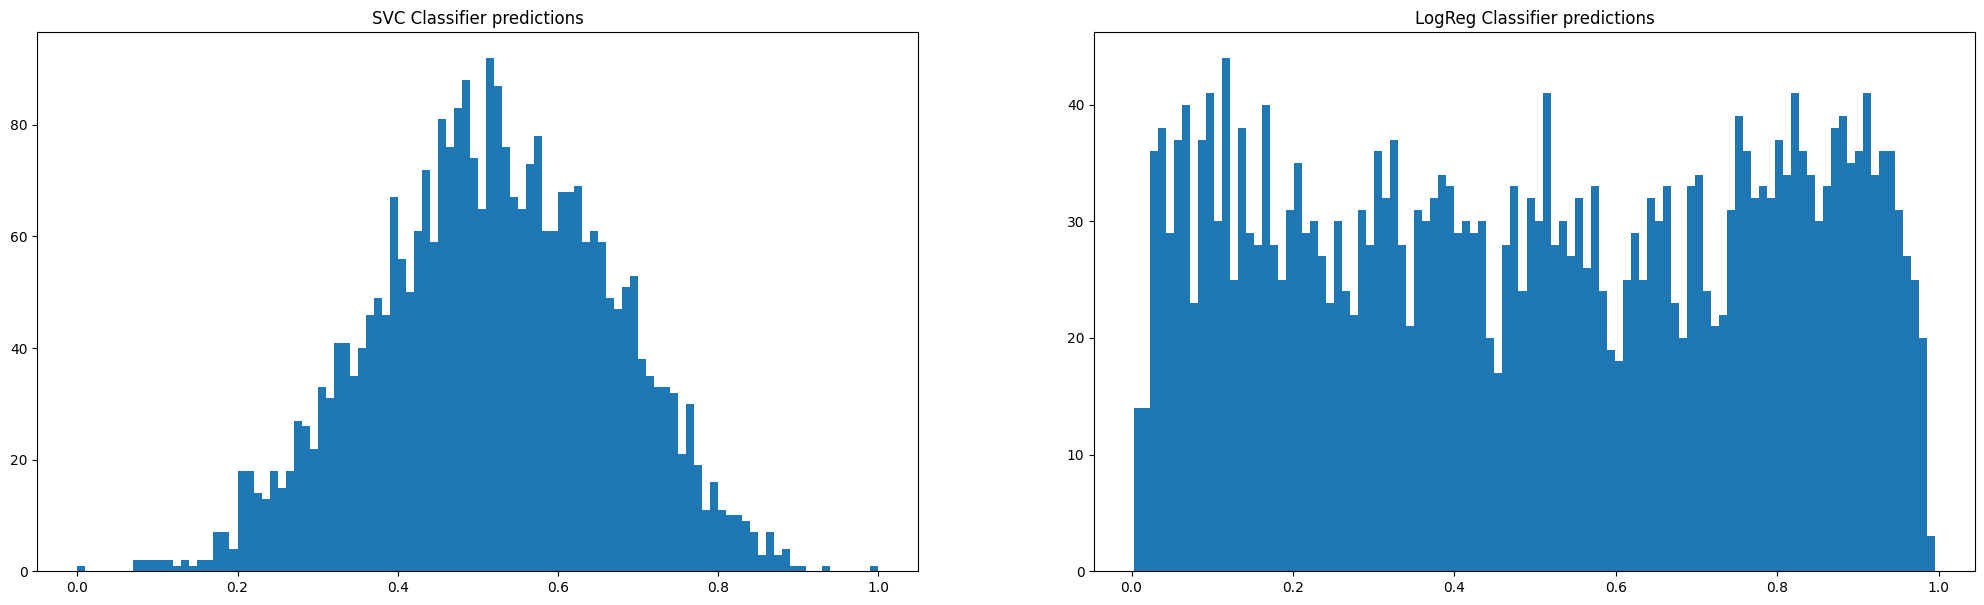

In [29]:
# your code here
f, ax = plt.subplots(1, 2, figsize=(25, 7))
ax[0].hist(true_svm_decision, bins=100)
ax[1].hist(y_log_proba, bins=100)

ax[0].set_title('SVC Classifier predictions')
ax[1].set_title('LogReg Classifier predictions')
plt.show()

**Вопрос:** Чем они различаются? Чем вы можете объяснить это?

**Ответ:** # your answer here

Предсказания SVM распределяются нормально, потому что модель пытается разделить два класса так, чтобы большинство объектов одного класса оказались с одной стороны разделяющей гиперплоскости, а другого — с другой. Объекты, которые ближе всего к гиперплоскости, вызывают неопределенность, что и приводит к вероятности около 0.5. В случае с логистической регрессией, она специально обучается выдавать более точные вероятности, поэтому предсказания, близкие к 0.5, встречаются реже.

Воспользуйтесь `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и постройте с его помощью  предсказания для тестовой выборки.

In [30]:
# your code here
from sklearn.calibration import CalibratedClassifierCV
svm_clf = SVC(C=best_c_SVM, kernel='linear')
calibrated_clf = CalibratedClassifierCV(svm_clf).fit(X_train, y_train)
resilt = calibrated_clf.predict_proba(X_test)[:,1]

<Figure size 800x800 with 0 Axes>

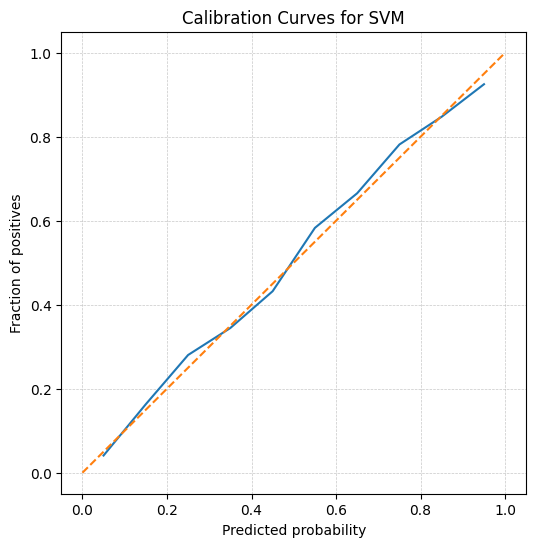

In [31]:
plt.figure(figsize=(8, 8))
plot_calibration_curve(y_test,resilt)
plt.xlabel('Predicted probability')
plt.ylabel('Fraction of positives')
plt.title("Calibration Curves for SVM")
plt.plot([0, 1], [0, 1], '--')
plt.grid(linestyle='--', linewidth=0.5, alpha=0.7)
plt.show()

**Вопрос:** Улучшились ли калибровочная кривая и качество калибровки?

**Ответ:** # your answer here да очень сильно улучшилась, стала очень близка к диагонали

##### __Бонус: Авторское решение__ (0.5 балла)

Реализуйте свою функцию для калибровки вероятностей, используя любой из известных подходов. Кратко опишите ваш подход и продемонстрируйте результаты. Ключевые слова для вдохновения: `Platt`, `Isotonic`.

In [32]:
# your code here

# Часть 2. Обработка категориальных переменных (4 балла + 1.5 бонус)

Как мы знаем, перекодировать категориальную переменную в список чисел (к примеру 1, 2, 3, ..., n) плохо, поскольку это бы задало на множестве ее значений некоторый порядок, не имеющий смысла.

В этой части мы рассмотрим два основных способа обработки категориальных значений:
- One-hot-кодирование
- Счётчики (CTR, mean-target кодирование, ...) — каждый категориальный признак заменяется на среднее значение целевой переменной по всем объектам, имеющим одинаковое значение в этом признаке.

Начнём с one-hot-кодирования. Допустим наш категориальный признак $f_j(x)$ принимает значения из множества $C=\{c_1, \dots, c_m\}$. Заменим его на $m$ бинарных признаков $b_1(x), \dots, b_m(x)$, каждый из которых является индикатором одного из возможных категориальных значений:
$$
b_i(x) = [f_j(x) = c_i]
$$

#### __Подготовка данных__

*(бесценный шаг)*

Разберем датасет [покупок велосипедов](https://www.kaggle.com/datasets/heeraldedhia/bike-buyers/): даны признаки покупателя, требуется предсказать, купит ли он/она велосипед



Замените пропуски в категориальных переменных на новую категорию (`'undefined'`)

Разделите признаки на 2 таблицы: категориальные и числовые признаки

In [33]:
import kagglehub

path = kagglehub.dataset_download("heeraldedhia/bike-buyers") +  "/bike_buyers.csv"

100%|██████████| 22.2k/22.2k [00:00<00:00, 25.9MB/s]

Extracting files...


In [34]:
df = pd.read_csv(path)
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,NaN,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [35]:
df.isna().sum()

,0
ID,0
Marital Status,7
Gender,11
Income,6
Children,8
Education,0
Occupation,0
Home Owner,4
Cars,9
Commute Distance,0


In [36]:
df.dtypes

,0
ID,int64
Marital Status,object
Gender,object
Income,float64
Children,float64
Education,object
Occupation,object
Home Owner,object
Cars,float64
Commute Distance,object


In [37]:
c = ['Marital Status', 'Gender', 'Home Owner']
df[c] = df[c].fillna('undefined')

In [38]:
X = df.drop(columns=['Purchased Bike'])
y = (df['Purchased Bike'] == 'Yes').astype('int64')

In [39]:
X_numerical = X[['Income','Children', 'Cars', 'Age']]
X_categorical = X[['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']]

In [40]:
df.head()

,ID,Marital Status,Gender,Income,Children,Education,Occupation,Home Owner,Cars,Commute Distance,Region,Age,Purchased Bike
0,12496,Married,Female,40000.0,1.0,Bachelors,Skilled Manual,Yes,0.0,0-1 Miles,Europe,42.0,No
1,24107,Married,Male,30000.0,3.0,Partial College,Clerical,Yes,1.0,0-1 Miles,Europe,43.0,No
2,14177,Married,Male,80000.0,5.0,Partial College,Professional,No,2.0,2-5 Miles,Europe,60.0,No
3,24381,Single,undefined,70000.0,0.0,Bachelors,Professional,Yes,1.0,5-10 Miles,Pacific,41.0,Yes
4,25597,Single,Male,30000.0,0.0,Bachelors,Clerical,No,0.0,0-1 Miles,Europe,36.0,Yes


In [41]:
X_categorical.isna().sum()

,0
Marital Status,0
Gender,0
Education,0
Occupation,0
Home Owner,0
Commute Distance,0
Region,0


В начале поработаем только с категориальными признаками

In [42]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_categorical, y, test_size=0.25, random_state=777, stratify=y)

#### __Задание 3. OrdinalEncoder__  (0.5 балла)

Закодируйте категориальные признаки с помощью `OrdinalEncoder`. Посчитайте качество (в этом задании будем работать c __`AUC-PR`__) при применении логистической регрессии. Замерьте время, потребовавшееся на обучение модели, с учетом кодирования признаков.

In [43]:
import time
from sklearn.preprocessing import OrdinalEncoder

In [44]:
# your code here
start_time = time.time()
encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = LogisticRegression()
model.fit(X_train_encoded, y_train)
y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]

training_time = time.time() - start_time

precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Training time: {training_time:.4f} seconds")
print(f"AUC-PR: {auc_pr:.4f}")

Training time: 0.0141 seconds
AUC-PR: 0.5887


#### __Задание 4. One-Hot Encoding__ (0.5 балла)



Закодируйте все категориальные признаки с помощью one-hot-кодирования. Обучите логистическую регрессию и посмотрите, как изменилось качество модели (в сравнении с тем, что было до кодирования). Измерьте время, потребовавшееся на кодирование категориальных признаков и обучение модели.

In [45]:
# your code here
from sklearn.preprocessing import OneHotEncoder

start_time = time.time()
encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)


model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)

training_time = time.time() - start_time
y_pred_proba = model.predict_proba(X_test_encoded)[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)

print(f"Training time: {training_time:.4f} seconds")
print(f"AUC-PR after One-Hot Encoding: {auc_pr:.4f}")


Training time: 0.0281 seconds
AUC-PR after One-Hot Encoding: 0.6663


Как можно заметить, one-hot-кодирование может сильно увеличивать количество признаков. Это сказывается на объеме необходимой памяти, особенно, если некоторый признак имеет большое количество значений.


#### __Задание 5. Mean-target Encoding__ (1 балл)

> Проблемы разрастания числа признаков можно избежать в другом способе кодирования категориальных признаков — mean-target encoding (для простоты будем называть это __счётчиками__). Сравним эффективность методов в рамках нашей маркетинговой задачи.

> Основная идея в том, что важны не сами категории, а значения целевой переменной, которые имеют объекты этой категории. Каждый категориальный признак мы заменим средним значением целевой переменной по всем объектам этой же категории:

$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1]}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)]}
$$

Закодируйте категориальные переменные с помощью счётчиков (ровно так, как описано выше, без каких-либо хитростей). Обучите логистическую регрессию и посмотрите на качество модели на тестовом множестве.

Сравните время обучения с предыдущими экспериментами (с учетом кодирования признаков).

In [46]:
class MeanTargetEncoder:
    def __init__(self, categorical_features, target_name):
        self.categorical_features = categorical_features
        self.target_name = target_name
        self.category_means = {}
        self.global_target_mean = None

    def fit(self, data, target):
        combined_data = pd.concat([data, pd.DataFrame(target, columns=[self.target_name])], axis=1)
        self.global_target_mean = target.mean()
        for feature in self.categorical_features:
            self.category_means[feature] = combined_data.groupby(feature)[self.target_name].mean()
        return self

    def transform(self, data):
        transformed_data = data.copy()
        for feature in self.categorical_features:
            transformed_data[feature] = transformed_data[feature].map(self.category_means[feature])
            transformed_data[feature].fillna(self.global_target_mean, inplace=True)
        return transformed_data

    def fit_transform(self, data, target):
        self.fit(data, target)
        return self.transform(data)


In [47]:
import warnings
warnings.filterwarnings('ignore')

In [48]:
start_time = time.time()
encoder = MeanTargetEncoder(categorical_features=['Marital Status', 'Gender', 'Education', 'Occupation',
                                                  'Home Owner', 'Commute Distance', 'Region'],target_name='Purchased Bike')
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)


model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)


end_time = time.time()

y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_prob)
print(f'AUC-PR: {auc_pr:.4f}')
print(f'Время обучения и кодирования: {end_time - start_time:.4f} секунд')



AUC-PR: 0.6575
Время обучения и кодирования: 0.0289 секунд


Время стало больше

##### __Бонус: Эффективная реализация (1 балл)__

Здесь и далее реализуйте вычисление счетчиков с помощью трансформера (наследуйтесь от классов `BaseEstimator, TransformerMixin` из `sklearn.base`). Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики нужно считать только по обучающей выборке в методе `fit`. Ваш трансформер должен принимать при инициализации список из категориальных признаков и изменять только их.

In [49]:
# your code here
from sklearn.base import BaseEstimator, TransformerMixin
class MeanTargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        self.means = {}

    def fit(self, X, y):
        data = X.copy()
        data['target'] = y
        for col in self.columns:
            self.means[col] = data.groupby(col)['target'].mean()
        return self

    def transform(self, X):
        X_copy = X.copy()
        for col in self.columns:
            X_copy[col] = X_copy[col].map(self.means.get(col, {}))
            X_copy[col].fillna(self.means[col].mean(), inplace=True)
        return X_copy

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)

In [50]:
start_time = time.time()
encoder = MeanTargetEncoder(columns=['Marital Status', 'Gender', 'Education', 'Occupation',
                                                  'Home Owner', 'Commute Distance', 'Region'])
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)


model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)


end_time = time.time()

y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_prob)
print(f'AUC-PR: {auc_pr:.4f}')
print(f'Время обучения и кодирования: {end_time - start_time:.4f} секунд')



AUC-PR: 0.6575
Время обучения и кодирования: 0.0239 секунд


_______

__Методы борьбы с переобучением счетчиков__


Отметим, что mean-target encoding признаки сами по себе являются классификаторами и, обучаясь на них, мы допускаем "утечку" целевой переменной в признаки. Это ведёт к __переобучению__, поэтому считать такие признаки необходимо таким образом, чтобы при вычислении для конкретного объекта его __целевая метка не использовалась__.

Это можно делать следующими способами:
1. Вычислять значение счётчика по всем объектам расположенным выше в датасете (например, если у нас выборка отсортирована по времени).
2. Вычислять по фолдам, то есть делить выборку на некоторое количество частей и подсчитывать значение признаков по всем фолдам кроме текущего (как делается в кросс-валидации).
3. Внесение некоторого шума в посчитанные признаки.

#### __Задание 6. Пошумим__  (0.5 балла)

Реализуйте корректное вычисление счётчиков самым простым способом — добавление шума к значениям.  При этом постарайтесь найти баланс между борьбой с переобучением и сохранением полезности признаков. Снова обучите логистическую регрессию, оцените качество.

In [51]:
# your code here

class MeanTargetEncoderWithNoise(BaseEstimator, TransformerMixin):
    def __init__(self, columns, target_col, noise_std=0.01):
        self.columns = columns
        self.target_col = target_col
        self.noise_std = noise_std
        self.category_means = {}
        self.global_target_mean = None

    def fit(self, X, y):
        data = X.copy()
        data[self.target_col] = y
        self.global_target_mean = y.mean()
        for col in self.columns:
            self.category_means[col] = data.groupby(col)[self.target_col].mean().to_dict()

        return self

    def transform(self, X):
        X_copy = X.copy()

        for col in self.columns:
            X_copy[col] = X_copy[col].map(self.category_means.get(col, {}))
            X_copy[col].fillna(self.global_target_mean, inplace=True)
            X_copy[col] += np.random.normal(0, self.noise_std, size=X_copy[col].shape)

        return X_copy


In [52]:
start_time = time.time()
encoder = MeanTargetEncoderWithNoise(columns=['Marital Status', 'Gender', 'Education', 'Occupation',
                                                  'Home Owner', 'Commute Distance', 'Region'],target_col='Purchased Bike')
X_train_encoded = encoder.fit_transform(X_train, y_train)
X_test_encoded = encoder.transform(X_test)


model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)


end_time = time.time()

y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

auc_pr = average_precision_score(y_test, y_pred_prob)
print(f'AUC-PR: {auc_pr:.4f}')
print(f'Время обучения и кодирования: {end_time - start_time:.4f} секунд')

AUC-PR: 0.6552
Время обучения и кодирования: 0.0323 секунд


**Вопрос:** Сделайте выводы. Помогло ли добавление шума? Почему?

**Ответ:** # your answer here
Шум уменьшает зависимость модели от "идеальных" значений счётчиков, особенно для редких категорий, что является важным шагом в борьбе с утечкой целевой переменной.

Введение шума добавляет элемент случайности, из-за чего результаты могут сильно варьироваться между разными запусками обучения. Это делает модель менее предсказуемой в плане качества.

##### __Бонус: другой подход__ (0.5 балла)

Посчитайте корректные счётчики первым или вторым способов из описанных выше (не забудьте добавить и шум).




In [53]:
# your code here

#### __Задание 7. Сглаживание счетчиков__  (1 балл)

> Теперь ответим на следующий вопрос: что будет, если некоторая категория встречается в выборке всего несколько раз? По этой причине производится сглаживание счётчиков. Например, на практике хорошие результаты показывает использование сглаживания средним по всей выборке:
$$
g_j(x, X) = \frac{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)][y_i = +1] + C \times \text{global_mean}}{\sum_{i=1}^{\ell} [f_j(x) = f_j(x_i)] + C}
$$
где $\text{global_mean}$ — доля объектов положительного класса в выборке, $C$ — параметр, определяющий степень сглаживания (можно использовать 10 или подобрать для каждого признака свой). Идея в том, что мы "разбавляем" среднее значение по категории глобальным средним значением. И тем меньше, чем большее количество объектов этой категории встречается в выборке.

> Вместо среднего значения целевой переменной для сглаживания можно использовать любое другое значение от 0 до 1 (этот параметр иногда называют $prior$). Можно сделать несколько признаков с разными значениями параметра. На практике в задачах бинарной классификации полезными бывают даже отрицательные значения!

Добавьте сглаживание, описанное выше и повторите эксперименты. Подберите $C$, чтобы качество было лучше, чем при использовании One-Hot-Encoding


In [54]:

class MeanTargetEncoderSmooth(BaseEstimator, TransformerMixin):
    def __init__(self, columns, C):
        self.columns = columns
        self.C = C
        self.means = {}
        self.global_mean = None

    def fit(self, X, y):
        data = X.copy()
        self.global_mean = y.mean()
        for col in self.columns:
            self.means[col] = {}
            categories = X[col].unique().tolist()
            idx_groups = X.groupby(col).indices
            for cat in categories:
                smoothed_value = (y.iloc[idx_groups[cat]].sum() + self.C * self.global_mean) / \
                                 (y.iloc[idx_groups[cat]].count() + self.C)
                self.means[col][cat] = smoothed_value
        return self

    def transform(self, X):
        data = X.copy()
        for col in self.columns:
            data[col] = data[col].map(self.means[col]).fillna(self.global_mean)
        return data

    def fit_transform(self, X, y):
        self.fit(X, y)
        return self.transform(X)


In [55]:
columns = ['Marital Status', 'Gender', 'Education', 'Occupation', 'Home Owner', 'Commute Distance', 'Region']

def tune_c(X_train, X_test, y_train, y_test):
    possible_c = np.linspace(0, 50, 50)
    best_c = None
    best_auc_pr = 0

    for c in possible_c:
        encoder = MeanTargetEncoderSmooth(columns, c)
        X_train_encoded = encoder.fit_transform(X_train, y_train)
        X_test_encoded = encoder.transform(X_test)
        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_encoded, y_train)
        y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]

        auc_pr = average_precision_score(y_test, y_pred_prob)


        if auc_pr > best_auc_pr:
            best_auc_pr = auc_pr
            best_c = c

    print(f"Лучший AUC-PR: {best_auc_pr:.4f} для C = {best_c}")
    return best_c, best_auc_pr


start_time = time.time()
best_c, best_auc_pr = tune_c(X_train, X_test, y_train, y_test)
end_time = time.time()

print(f"Время выполнения: {end_time - start_time:.4f} секунд")




Лучший AUC-PR: 0.6728 для C = 6.122448979591837
Время выполнения: 1.8057 секунд


#### **Задание 8. Числовые или категориальные?**  (0.5 балла)

Теперь добавим числовые признаки к счётчикам (тем, которые дали наибольший прирост качества).


Проверьте их на наличие выбросов и заполните пропуски средним или медианой, подумайте, что лучше в условиях наших данных



In [56]:
X_numerical = X[['Income','Children', 'Cars', 'Age']]

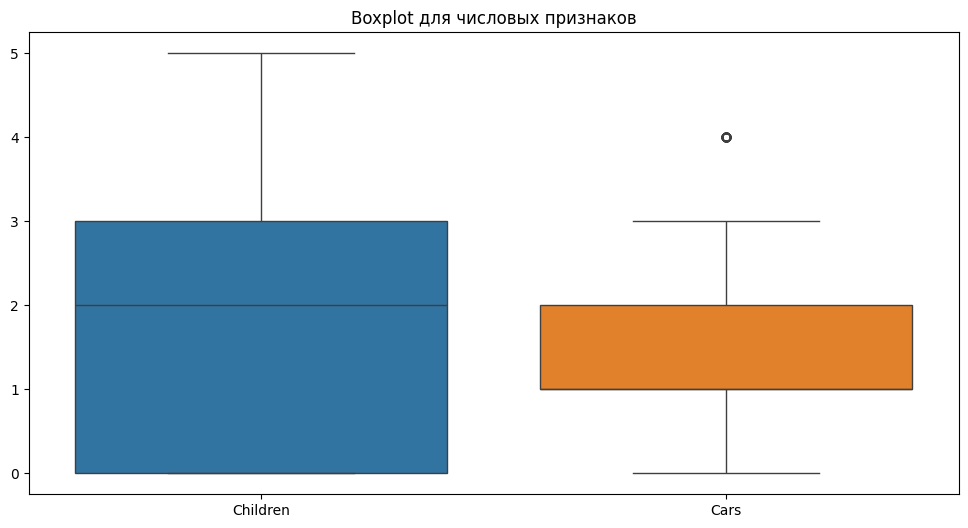

In [57]:
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.boxplot(X[['Children', 'Cars']])
plt.title('Boxplot для числовых признаков')
plt.show()#особо нет выбросов

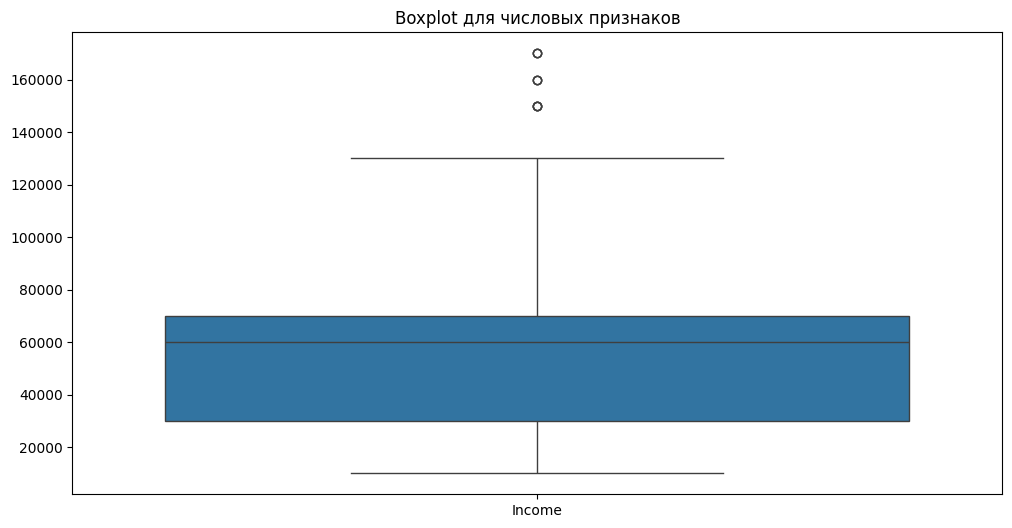

In [58]:
plt.figure(figsize=(12, 6))
sns.boxplot(X[['Income']])
plt.title('Boxplot для числовых признаков')
plt.show()

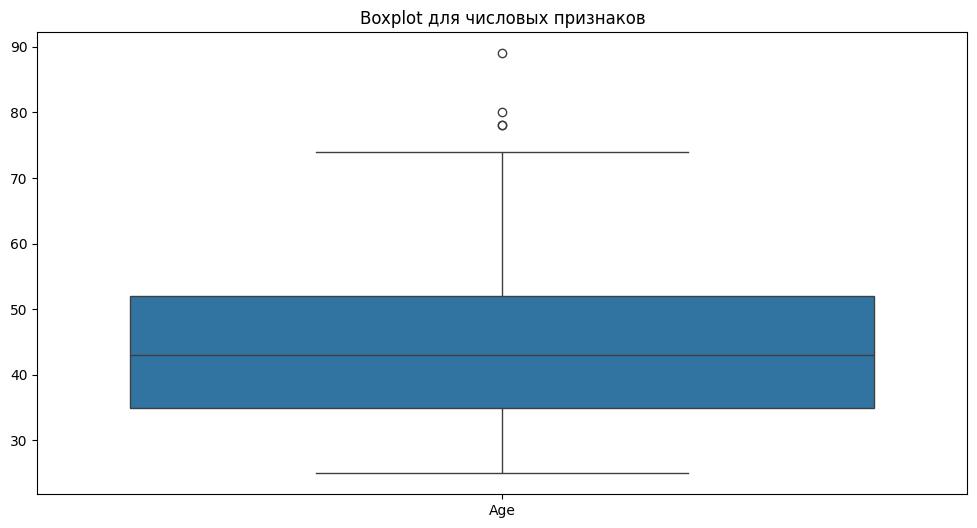

In [59]:
plt.figure(figsize=(12, 6))
sns.boxplot(X[['Age']])
plt.title('Boxplot для числовых признаков')
plt.show()#особо нет выбросов

Особо нельзя заметить много выбросов, поэтому можем заменить на среднее

In [60]:
numeric_columns = X_numerical.columns
for feature in numeric_columns:
    mean_value = X_numerical[feature].mean()
    X_numerical[feature].fillna(mean_value, inplace=True)

In [61]:
X_numerical.isna().sum()

,0
Income,0
Children,0
Cars,0
Age,0


In [62]:
X_full = pd.concat((X_categorical, X_numerical), axis=1)
X_train, X_test, y_train, y_test = train_test_split(X_full, y, test_size=0.25, random_state=42)

Сейчас для числовых признаков мы ищем линейную зависимость, что в общем случае может быть неверной гипотезой. Тем не менее, у этих признаков есть довольно много уникальных значений (сколько?), поэтому применять к ним one-hot кодирование может оказаться излишним. Попробуйте закодировать эти признаки с помощью счетчиков. Стало ли лучше?

In [63]:
# your code here
for col in ['Income','Children', 'Cars', 'Age']:
    print(f'unique values for {col} : {len(X_train[col].unique())}')

unique values for Income : 17
unique values for Children : 7
unique values for Cars : 6
unique values for Age : 54


In [64]:
columns = columns + ['Income', 'Children', 'Cars', 'Age']

start_time = time.time()
mtargetenc = MeanTargetEncoderSmooth(columns, best_c)
X_train_trans = mtargetenc.fit_transform(X_train, y_train)
X_test_trans = mtargetenc.transform(X_test)
model = LogisticRegression(max_iter=1000)
model.fit(X_train_trans, y_train)

y_pred_prob = model.predict_proba(X_test_trans)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_prob)

end_time = time.time()

print(f"Время выполнения: {end_time - start_time:.4f} секунд")
print(f"AUC-PR: {auc_pr:.4f}")


Время выполнения: 0.0677 секунд
AUC-PR: 0.6969


> __Замечание.__ Усложнение методов вычисления счётчиков не делают результаты модели гарантированно лучше. Особенно с учётом того, что логистическая регрессия не такая сложная модель, чтобы переобучаться. Поэтому вы необязательно должны были получать на каждом шаге всё лучшие и лучшие результаты (но необходимые результаты у вас должны были получиться).



Как мы могли пронаблюдать, счётчики являются конкурентной альтернативой one-hot-кодированию. Опишите, какие плюсы и минусы использования счётчиков по сравнению с one-hot-кодированием вы заметили.

__Ответ:__ # your answer here Преимущества: Меньше признаков, лучше захватывает связь с целевой переменной.
Минусы: Риск переобучения, особенно для редких категорий

# Часть 3. Отбор признаков (2 балла)

Загрузим данные [UCI Adult Dataset](https://archive.ics.uci.edu/ml/datasets/Adult). Этот набор данных содержит информацию о годовых доходах отдельных людей. В качестве признакового описания используется различная информация о человеке (образование, профессия, брачный статус и т.д.). Целевая переменная является бинарной: больше ли годовой доход 50K долларов или нет.

In [65]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data

--2024-11-28 20:34:33--  https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘adult.data’

adult.data              [     <=>            ]   3.79M  3.65MB/s    in 1.0s    

2024-11-28 20:34:35 (3.65 MB/s) - ‘adult.data’ saved [3974305]



In [66]:
columns = [
    'age', 'workclass', 'fnlwgt', 'education', 'education-num',
    'marital-status', 'occupation', 'relationship', 'race', 'sex',
    'capital-gain', 'capital-loss', 'hours-per-week', 'native-country',
    'income'
]

df = pd.read_csv('adult.data', header=None, names=columns)
df['income'] = (df['income'] != " <=50K").astype('int32')
df.sample()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
10611,38,Private,372559,Some-college,10,Married-civ-spouse,Craft-repair,Husband,Black,Male,0,0,40,United-States,0


Важной частью процесса построения модели является отбор признаков. На практике многие признаки оказывают малое влияние на модель (при этом их расчёт занимает время) или даже негативно сказываются на качестве модели. Попробуем несколько подходов отбора признаков, оценим, как они влияют на качество модели и сколько времени занимают.



Разделите выборку на обучающую и тестовую в соотношении 3:1. Зафиксируйте `random_state=777`, также используйте `stratify=True`.

In [67]:
# your code here
X = df.drop(columns=['income'])
y = df['income']

In [68]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
test_size=0.25,random_state=777, stratify=y)

Давайте закодируем все категориальные признаки с помощью One-hot Encoding. Сколько новых признаков мы получим?

In [69]:
# your code here
X_train.columns

Index(['age', 'workclass', 'fnlwgt', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loss', 'hours-per-week', 'native-country'],
      dtype='object')

In [70]:
X_train.dtypes

,0
age,int64
workclass,object
fnlwgt,int64
education,object
education-num,int64
marital-status,object
occupation,object
relationship,object
race,object
sex,object


In [71]:
categorical = ['workclass', 'education', 'marital-status', 'occupation',
           'relationship', 'race', 'sex','native-country']
numeric = ['age', 'fnlwgt', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']

In [72]:
X_train.shape

(24420, 14)

In [73]:
encoder = OneHotEncoder(sparse_output=False)
X_train_enc = pd.DataFrame(encoder.fit_transform(X_train[categorical]),columns=encoder.get_feature_names_out(input_features=categorical)).reset_index()
X_test_enc = pd.DataFrame(encoder.transform(X_test[categorical]),columns=encoder.get_feature_names_out(input_features=categorical)).reset_index()


In [74]:
X_train_encoded = pd.concat((X_train_enc, X_train[numeric].reset_index()), axis = 1)
X_test_encoded = pd.concat((X_test_enc, X_test[numeric].reset_index()), axis = 1)

In [75]:
X_train_encoded.drop(columns ='index', inplace=True)
X_test_encoded.drop(columns ='index', inplace=True)

In [76]:
X_train_encoded.shape

(24420, 108)

Стало на 94 больше признаков

В качестве основной модели будем использовать логистическую регрессию, а целевой метрики — `AUC-PR`. Обучите модель и посчитайте качество на тестовой выборке. Давайте запомним полученное значение.

In [77]:
print(X_train_encoded.shape)
print(y_train.shape)
print(y_test.shape)

(24420, 108)
(24420,)
(8141,)


In [78]:
# your code here
model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded, y_train)

y_pred_prob = model.predict_proba(X_test_encoded)[:, 1]
auc_pr = average_precision_score(y_test, y_pred_prob)
print(f"AUC-PR: {auc_pr:.4f}")

AUC-PR: 0.7245


Допустим, мы хотим оставить только 40 лучших признаков.

Заметим, что нельзя оценивать качество по тестовой выборке, иначе мы можем переобучиться, как, например, при настройке гиперпараметров. Разделите обучающую выборку на 2 части, одну из которых, используйте для валидации. Исходную тестовую выборку стоит использовать только для финальной оценки качества после процедуры фильтрации

In [79]:
# your code here
X_train_new, X_val, y_train_new, y_val = train_test_split(
    X_train_encoded, y_train, test_size=0.25, random_state=42
)

In [80]:
X_train_encoded.shape

(24420, 108)

Попробуем сделать это следующими способами:

#### __Задание 9. Встроенные методы (0.5 балла)__

Начнём с отбора признаков с помощью модели. У разных алгоритмов есть разные встроенные способы оценки вклада признаков в предсказание. Как известно, у линейной модели за это отвечают веса, а значит, их модуль можно интерпретировать как важность. Такой метод отбора называются встроенным или embedded method, так как он заложен в особенности модели.

Оставьте 40 признаков с наибольшим модулем соответствующего параметра линейной модели. Обучите модели заново и оцените её качество. Замерьте скорость такого отбора признаков.



In [81]:
start_time = time.time()
feature_importance = np.abs(model.coef_[0])
top_features_idx = np.argsort(feature_importance)[-40:]
top_features_names = [X_train_new.columns[i] for i in top_features_idx]

X_train_selected = X_train_new[top_features_names]
X_val_selected = X_val[top_features_names]

model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_selected, y_train_new)

y_val_pred_prob_selected = model_selected.predict_proba(X_val_selected)[:, 1]
auc_pr_val_selected = average_precision_score(y_val, y_val_pred_prob_selected)

X_test_selected = X_test_encoded[top_features_names]
y_test_pred_prob = model_selected.predict_proba(X_test_selected)[:, 1]
auc_pr_test = average_precision_score(y_test, y_test_pred_prob)

end_time = time.time()

print(f"Selected Features: {len(top_features_names)}")
print(f"Time elapsed for feature selection: {end_time - start_time:.4f} seconds")
print(f"Validation AUC-PR after feature selection: {auc_pr_val_selected:.4f}")
print(f"Test AUC-PR after feature selection: {auc_pr_test:.4f}")

Selected Features: 40
Time elapsed for feature selection: 0.1032 seconds
Validation AUC-PR after feature selection: 0.6962
Test AUC-PR after feature selection: 0.6866


Изменилось ли качество? Как?

Качество немного ухудшилось

Подумаем, что мы не учли. Мы действовали в предположении, что признаки вносят вклад равномерно, и не учитывали их масштаб. Если мы умножим один из признаков в 100 раз, то без учёта регуляризации его вес уменьшится в эти же 100 раз. А мы на основе этого отбираем признаки! Давайте сначала отмасштабируем признаки одним из способов, а только потом будем удалять признаки.

Помните, что не все способы одинаково хороши, особенно в условиях наличия выбросов

Кстати, в таком случае надо пересчитать качество на всех признаках (сделайте это ниже). Если вы сделали нормирование признаков в самом начале, то попробуйте отобрать признаки на неотмасштабированных данных.

Что получилось?

In [82]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_new[numeric])
X_val_scaled = scaler.transform(X_val[numeric])

X_train_encoded_s = np.hstack([X_train_scaled, X_train_new.drop(numeric, axis=1).values])
X_val_encoded_s = np.hstack([X_val_scaled, X_val.drop(numeric, axis=1).values])

model = LogisticRegression(max_iter=1000)
model.fit(X_train_encoded_s, y_train_new)
y_test_pred_prob = model.predict_proba(X_val_encoded_s)[:, 1]
auc_pr_test = average_precision_score(y_val, y_test_pred_prob)
print('AUC-PR: %.5f' % auc_pr_test)

AUC-PR: 0.76913


Стало лучше, чем было изначально

Вопрос на засыпку: one-hot кодирование возвращает нам единичные признаки-индикаторы. Попробуйте также отскалировать их, как и обычные числовые, и снова выбрать 40 главных по вкладу признаков. Изменился ли их список? Изменится ли качество?

In [83]:
# your code here
scaler = StandardScaler()
train = X_train_new
val = X_val
test = X_test_encoded
X_train_scaled = scaler.fit_transform(train)
X_val_scaled = scaler.transform(val)
X_test_scaled = scaler.transform(test)

top_features_idx = np.argsort(feature_importance)[-40:]
X_train_top_features = X_train_scaled[:, top_features_idx]
X_val_top_features = X_val_scaled[:, top_features_idx]
X_test_top_features = X_test_scaled[:, top_features_idx]

model_selected = LogisticRegression(max_iter=1000)
model_selected.fit(X_train_top_features,  y_train_new)
y_test_pred_prob = model_selected.predict_proba(X_test_top_features)[:, 1]
auc_pr_test = average_precision_score(y_test, y_test_pred_prob)

print(f"Test AUC-PR: {auc_pr_test:.4f}")


Test AUC-PR: 0.6867


Снова стало хуже, так как нет необходимости скалировать признаки, к которым применялось one-hot кодирование

#### __Задание 10. Методы фильтрации (0.5 балла)__


Давайте отбирать признаки умнее, а именно через подсчёт некоторой функции для каждого признака. На основании значений этой функции будем оставлять наиболее важные признаки. Методы этого семейства называют фильтрующими или  filter methods.

Одна из самых простых функция - корреляция между признаком и целевой переменной. Подумайте, какая взаимосвязь между корреляцией и предсказательной способностью модели, и как бы вы использовали информацию о корреляции для отбора признаков

**Ответ:** # your code here

Посчитайте корреляцию каждого признака с таргетом и отфильтруйте 40 признаков исходя из того, что вы описали, после чего замерьте качество и время отбора



Будем использовать данные, где отскалированы только численные показатели

In [84]:
# your code here
correlations = []
for feature in X_train_new.columns:
    correlation = np.corrcoef(X_train_new[feature], y_train_new)[0, 1]
    correlations.append((feature, correlation))

correlations = sorted(correlations, key=lambda x: abs(x[1]), reverse=True)
top_features_names = [x[0] for x in correlations[:40]]

X_train_top = X_train_new[top_features_names]
X_val_top = X_val[top_features_names]
X_test_top = X_test_encoded[top_features_names]

start_time = time.time()
model = LogisticRegression(max_iter=1000)
model.fit(X_train_top, y_train_new)
y_pred_val = model.predict_proba(X_val_top)[:, 1]
y_pred_test = model.predict_proba(X_test_top)[:, 1]
end_time = time.time()

auc_pr_val = average_precision_score(y_val, y_pred_val)
auc_pr_val = average_precision_score(y_test, y_pred_test)
print(f"Validation AUC-PR: {auc_pr_val:.4f}")
print(f"Test AUC-PR: {auc_pr_test:.4f}")
print(f"Selected Features: {len(top_features_names)}")
print(f"Time elapsed for feature selection: {end_time - start_time:.4f} seconds")


Validation AUC-PR: 0.6784
Test AUC-PR: 0.6867
Selected Features: 40
Time elapsed for feature selection: 0.1287 seconds


В качестве еще одной функция можно считать t-статистику:

$$t(j) = \frac{|\mu_+ - \mu_-|}{\sqrt{\frac{n_+ \sigma^2_+ + n_- \sigma^2_-}{n_+ + n_-}}},$$

где $\mu$, $\sigma$, $n$ соответственно среднее, стандартное отклонение и количество объектов каждого из классов.

Оставьте 40 признаков с наибольшим значением $t$, замерьте качество и скорость отбора признаков.

In [85]:
def compute_t(X, y):
    data = pd.concat((X, pd.DataFrame(y, columns=['target'])), axis=1)
    positive = data[data['target'] == 1].drop(columns='target')
    negative = data[data['target'] == 0].drop(columns='target')

    denominator = np.sqrt(
        (positive.shape[0] * np.var(positive, axis=0) +
         negative.shape[0] * np.var(negative, axis=0)) /
        (positive.shape[0] + negative.shape[0])
    )
    t_statistics = np.abs(np.mean(positive, axis=0) - np.mean(negative, axis=0)) / denominator
    return t_statistics

start_time = time.time()
t_stats = compute_t(X_train_new, y_train_new)
top_features_idx = t_stats.nlargest(40).index

top_features_names = top_features_idx.tolist()
X_train_top = X_train_new[top_features_names]
X_val_top = X_val[top_features_names]
X_test_top = X_test_encoded[top_features_names]

X_train_top = X_train_new[top_features_names]
X_val_top = X_val[top_features_names]
X_test_top = X_test_encoded[top_features_names]

model = LogisticRegression(max_iter=1000)
model.fit(X_train_top, y_train_new)
y_pred_val = model.predict_proba(X_val_top)[:, 1]
y_pred_test = model.predict_proba(X_test_top)[:, 1]
end_time = time.time()
auc_pr_val = average_precision_score(y_val, y_pred_val)
auc_pr_test = average_precision_score(y_test, y_pred_test)

print(f"Selected Features: {len(top_features_names)}")
print(f"Time elapsed for feature selection: {end_time - start_time:.4f} seconds")
print(f"Validation AUC-PR: {auc_pr_val:.4f}")
print(f"Test AUC-PR: {auc_pr_test:.4f}")


Selected Features: 40
Time elapsed for feature selection: 0.1213 seconds
Validation AUC-PR: 0.6858
Test AUC-PR: 0.6706


#### __Задание 11. Методы-обёртки__ (1 балл)

Третий из рассматриваемых нами методов работает следующим образом: мы исключаем признаки по очереди и смотрим, как это влияет на качество. Удаляем признаки таким жадным способом, пока не окажется выполненым некоторое условие (количество признаков или ухудшение качества). Более конкретно, алгоритм выглядит так:

- $k$ - число признаков, которых мы хотим оставить
- $m$ - число признаков, которых мы выбрасываем на каждой итерации, оно же длина шага

Шаг $i$:
- $F_i$ - набор признаков (равный всему множеству признаков на i=0)
- $M_i$ - их число, в общем случае $\max(k, M_{i-1} - m)$
1. Если признаков осталось ровно $k$, либо метрика стала уменьшаться более, чем на $\epsilon$ — останавливаемся (не наш случай, но так тоже можно)
2. Обучаем модель $a_i$ на наборе $F_i$, после чего оцениваем важность признаков (любым из способов выше или какими-нибудь ещё)
3. Отбираем $\min(M_i - k, m)$ наиболее бесполезных, согласно пункту 2, признаков (берем $m$, если можем, иначе оставляем вплоть до k), удаляем, переходим к следующему шагу

Снова оставьте только 40 признаков и оцените качество на тестовой выборке. Подберите длину шага из каких-то соображений (каких, кстати?) и замерьте время работы метода

In [827]:
len(X_train_new.columns)

108

In [828]:
from sklearn.metrics import precision_recall_curve, auc
target_features = 40

m = 17

columns = X_train_new.columns.tolist()

while len(columns) > target_features:
    scores = []
    for feature in columns:
        model = LogisticRegression(max_iter=1000).fit(X_train_new[columns].drop(columns=[feature]), y_train_new)
        y_pred_val = model.predict_proba(X_val[columns].drop(columns=[feature]))[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
        scores.append(auc(recall, precision))

    least_important_idx = np.argsort(scores)[:m]
    least_important_features = [columns[i] for i in least_important_idx]

    for feature in least_important_features:
        columns.remove(feature)

    print(f"Excluded features: {least_important_features}, AUC-PR: {np.min(np.array(scores)[least_important_idx]):.4f}")

model = LogisticRegression(max_iter=1000)
model.fit(X_train_new[columns], y_train_new)


y_pred_test = model.predict_proba(X_test_encoded[columns])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
test_auc_pr = auc(recall, precision)

print(f"Remaining features: {len(columns)}")
print(f"Validation AUC-PR: {test_auc_pr:.4f}")


Excluded features: ['capital-gain', 'sex_ Female', 'occupation_ Other-service', 'education_ Some-college', 'workclass_ Self-emp-not-inc', 'marital-status_ Never-married', 'occupation_ Prof-specialty', 'occupation_ Farming-fishing', 'workclass_ Private', 'relationship_ Unmarried', 'occupation_ Machine-op-inspct', 'race_ White', 'education_ Masters', 'education_ 7th-8th', 'marital-status_ Divorced', 'relationship_ Own-child', 'education_ Prof-school'], AUC-PR: 0.6791
Excluded features: ['marital-status_ Married-AF-spouse', 'workclass_ Federal-gov', 'race_ Asian-Pac-Islander', 'education_ Assoc-voc', 'marital-status_ Married-spouse-absent', 'education_ 11th', 'education_ 1st-4th', 'native-country_ France', 'native-country_ Poland', 'occupation_ Transport-moving', 'sex_ Male', 'education_ Preschool', 'occupation_ Priv-house-serv', 'native-country_ Cambodia', 'native-country_ ?', 'native-country_ Jamaica', 'marital-status_ Married-civ-spouse'], AUC-PR: 0.6156
Excluded features: ['native-cou

In [829]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train_new[columns], y_train_new)


y_pred_test = model.predict_proba(X_test_encoded[columns])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
test_auc_pr = auc(recall, precision)

print(f"Remaining features: {len(columns)}")
print(f"Test AUC-PR: {test_auc_pr:.4f}")

Remaining features: 40
Validation AUC-PR: 0.2855


Сделаем шаг - 17, так как очень долго выполняется и пусть за один раз удаляется хотя бы по 17. Получается 17*4 = 68 и остается 40 признаков

Получилось очень маленькое Test AUC-PR, может быть связано с тем, что выбран очень большой шаг(17), можем попробовать взять шаг = 1, это самый идеальный вариант, но это будет очень долго

In [ ]:
from sklearn.metrics import precision_recall_curve, auc
target_features = 40

m = 1

columns = X_train_new.columns.tolist()

while len(columns) > target_features:
    scores = []
    for feature in columns:
        model = LogisticRegression(max_iter=1000).fit(X_train_new[columns].drop(columns=[feature]), y_train_new)
        y_pred_val = model.predict_proba(X_val[columns].drop(columns=[feature]))[:, 1]
        precision, recall, _ = precision_recall_curve(y_val, y_pred_val)
        scores.append(auc(recall, precision))

    least_important_idx = np.argsort(scores)[:m]
    least_important_features = [columns[i] for i in least_important_idx]

    for feature in least_important_features:
        columns.remove(feature)

    print(f"Excluded features: {least_important_features}, AUC-PR: {np.min(np.array(scores)[least_important_idx]):.4f}")

model = LogisticRegression(max_iter=1000)
model.fit(X_train_new[columns], y_train_new)


y_pred_test = model.predict_proba(X_test_encoded[columns])[:, 1]
precision, recall, _ = precision_recall_curve(y_test, y_pred_test)
test_auc_pr = auc(recall, precision)

print(f"Remaining features: {len(columns)}")
print(f"Validation AUC-PR: {test_auc_pr:.4f}")

Очень долго работает(больше часа), но по логике должен быть самый лучший результат

Стоит отметить, что с помощью такого метода можно пойти и в обратную сторону. Попробуйте _добавлять_ самые полезные признаки в выборку до тех пор, пока не наберется 40 штук. Найдется ли порог, при котором добавление следующих признаков будет только ухудшать качество модели?

Давайте подведём итоги по отбору признаков. Назовите преимущества и недостатки каждого из методов. Какой метод привёл к наилучшему качеству?

**Ответ:** # your code here
Жадный метод отбора признаков показал наилучший результат по качеству (AUC-PR), поскольку учитывает взаимосвязи между признаками, но требует больше вычислительных ресурсов. Встроенный метод быстрый и прост, но чувствителен к масштабированию и коллинеарности, что ограничивает его точность. Методы фильтрации, такие как корреляция с целевой переменной и t-статистика, быстрее, но не всегда эффективны, особенно при наличии сложных зависимостей между признаками. В целом, жадный метод дал лучшие результаты, но был более медленным(очень медленный).

# Часть 4. Оценка экономического эффекта модели (2 балла)



В данной части мы займемся тем, что от вас скорее всего потребуется на реальной работе (помимо перекладки `json`, разумеется). А именно:
- мы соберем несколько специализированных метрик качества,
- попытаемся настроить модель на максимизацию _прибыли_,
- оценим, сколько вообще получится заработать на этом.

Разумеется, здесь будет сделано множество упрощающих жизнь допущений, но обо всем по порядку. Если вы всё прослушали на экономике, то напомним, что выручка — это сколько денег нам принесли клиенты, а прибыль — выручка за вычетом расходов на зарплату и прочее.


#### __Задание 12. Прогноз по доходам и расходам__ (1 балл)

В этой части мы будем работать с данными [UCI Bank Marketing Dataset](https://archive.ics.uci.edu/ml/datasets/bank+marketing). Этот датасет содержит информацию о банковском телефонном маркетинге.

__Объектом__ здесь является телефонный звонок потенциальному клиенту с предложением некоторой услуги (утверждается, что это краткосрочный депозит). В качестве признакового описания используются характеристики клиента (образование, брак и т.д.), данные о звонке и различные экономические индикаторы - более подробная информация представлена в файле `bank-additional-names.txt`.
__Целевая переменная__ - ответ клиента (согласился ли он открыть депозит?)

In [841]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
!unzip bank-additional.zip
df = pd.read_csv('bank-additional/bank-additional-full.csv', sep=';')

--2024-11-28 18:42:04--  https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank-additional.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘bank-additional.zip.2’

bank-additional.zip     [  <=>               ] 434.15K  1.38MB/s    in 0.3s    

2024-11-28 18:42:05 (1.38 MB/s) - ‘bank-additional.zip.2’ saved [444572]

Archive:  bank-additional.zip
replace bank-additional/.DS_Store? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [842]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [843]:
X = df.drop(columns=['duration', 'y'])
y = (df.y == 'yes')

В этой части не нужно делить выборку - мы будем использовать кросс-валидацию.  Используйте наиболее подходящие с вашей точки зрения параметры и их значения (`shuffle`, `stratify`, число фолдов, ...). По кросс-валидации у вас получится несколько вариантов обучающей и тестовой выборки. Для удобства можно воспользоваться шаблоном ниже, который по ходу выполнения задания будет обрастать функционалом. Как обычно, это необязательно, но сохранять результаты экспериментов очень и очень желательно, в конце мы будем их сравнивать

In [ ]:
from collections import defaultdict
from sklearn.model_selection import KFold

def cross_validate(
    X,
    y,
    n_splits=5,
    random_state=None,
    shuffle=False,
    # другие аргументы, которые могут вам пригодиться дальше по пунктам
):
    metrics = []
    # или любой другой фолд, посмотрите в model_selection
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    for train_index, test_index in kf.split(X):

        # возьмите датасет и обучите модель
        # your code here

        # посчитайте метрики, которые вам нужны и добавьте результаты с каждого фолда
        metric_dict = {
            # "metric_key": metric_value
        }
        metrics.append(metric_dict)

    # осталось только красиво всё обернуть
    return pd.DataFrame(metrics)

Выберите метрику классификации, которая вам кажется подходящей, и обучите логистическую регрессию на каждой обучающей выборке (закодируйте категориальные признаки способом, который выше вам понравился больше всех, отнормируйте числовые, гиперпараметры оставьте по умолчанию), сделайте предсказания для соответствующих тестовых выборок, выведите результаты

5 фолдов — это стандартный выбор, который часто используется в кросс-валидации. Он является хорошим компромиссом между вычислительными затратами и точностью.

shuffle=True — гарантирует, что данные будут случайным образом перемешаны перед разделением на фолды. Это предотвращает зависимость от порядка, в котором данные представлены в исходном наборе, и улучшает общее качество модели.

Выберем метрику AUC-PR, так как она лучше подходит для оценки моделей при несбалансированных классах, где важно минимизировать как ложные срабатывания, так и пропущенные положительные случаи.

Воспользуемся самым простым OneHotEncoder, так как вррде не должно произойти проблемы с переобучением

In [834]:
X.dtypes

,0
age,int64
job,object
marital,object
education,object
default,object
housing,object
loan,object
contact,object
month,object
day_of_week,object


In [855]:
categorical = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome']
numeric = ['age', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']


In [856]:
X[categorical]

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome
0,housemaid,married,basic.4y,no,no,no,telephone,may,mon,nonexistent
1,services,married,high.school,unknown,no,no,telephone,may,mon,nonexistent
2,services,married,high.school,no,yes,no,telephone,may,mon,nonexistent
3,admin.,married,basic.6y,no,no,no,telephone,may,mon,nonexistent
4,services,married,high.school,no,no,yes,telephone,may,mon,nonexistent
...,...,...,...,...,...,...,...,...,...,...
41183,retired,married,professional.course,no,yes,no,cellular,nov,fri,nonexistent
41184,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,nonexistent
41185,retired,married,university.degree,no,yes,no,cellular,nov,fri,nonexistent
41186,technician,married,professional.course,no,no,no,cellular,nov,fri,nonexistent


In [858]:
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score

In [861]:
def cross_validate(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    scaler = StandardScaler()

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_encoded = encoder.fit_transform(X_train[categorical])
        X_test_encoded = encoder.transform(X_test[categorical])

        X_train_scaled = scaler.fit_transform(X_train[numeric])
        X_test_scaled = scaler.transform(X_test[numeric])

        X_train_combined = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
        X_test_combined = np.concatenate((X_test_encoded, X_test_scaled), axis=1)


        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_combined, y_train)

        y_pred_prob = model.predict_proba(X_test_combined)[:, 1]


        auc_pr = average_precision_score(y_test, y_pred_prob)

        metrics.append({
            "fold": fold + 1,
            "AUC-PR": auc_pr
        })
        print(f"Fold {fold + 1}: AUC-PR = {auc_pr:.4f}")


    return pd.DataFrame(metrics)
results = cross_validate(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True)

average_auc_pr = results["AUC-PR"].mean()
print(f"Average AUC-PR: {average_auc_pr:.4f}")


Fold 1: AUC-PR = 0.4306
Fold 2: AUC-PR = 0.4727
Fold 3: AUC-PR = 0.4498
Fold 4: AUC-PR = 0.4547
Fold 5: AUC-PR = 0.4559
Average AUC-PR: 0.4527


Допустим, работники вашего колл-центра получают за один звонок клиенту 2 доллара. При согласии клиента на предлагаемые условия он принесет в банк 10 долларов. Предположим, что всем положительным прогнозам ваши сотрудники решили позвонить.

В качестве бизнес-метрики в нашей задаче мы будем считать прибыль aka `profit`, соответственно лучшую модель будем выбирать исходя из этого.
Посчитайте на всех тестовых выборках выручку и сохраните результаты для бизнес-метрики вместе с предыдущей метрикой, которую вы выбрали

Ответьте на вопросы:
- Сколько денег вы в среднем заработаете?
- Какое получилось стандартное отклонение профита?
- Сколько из заработанных денег придётся отдать операторам вашего колл-центра?
- Пропорциональна ли бизнес-метрика выбранной метрике классификации?

In [872]:
from scipy.stats import pearsonr

def cross_validate_with_profit(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True):
    metrics = []
    auc_pr_scores = []
    revenue = np.empty(0)
    expenses = 0
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    scaler = StandardScaler()

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_encoded = encoder.fit_transform(X_train[categorical])
        X_test_encoded = encoder.transform(X_test[categorical])

        X_train_scaled = scaler.fit_transform(X_train[numeric])
        X_test_scaled = scaler.transform(X_test[numeric])

        X_train_combined = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
        X_test_combined = np.concatenate((X_test_encoded, X_test_scaled), axis=1)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_combined, y_train)

        y_pred_prob = model.predict_proba(X_test_combined)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        auc_pr = average_precision_score(y_test, y_pred_prob)
        auc_pr_scores.append(auc_pr)

        metrics.append((y_test, y_pred))

        revenue = np.append(revenue, ((y_test == 1) & (y_test == y_pred)).sum()*10)
        expenses += np.sum(y_pred) / n_splits

    rev_mean = revenue.mean()
    rev_std = revenue.std()

    print(f'В среднем заработаем: {np.round(rev_mean, 2)}')
    print(f'Стандартное отклонение выручки: {np.round(rev_std, 2)}')
    print(f'В среднем отдадим в колл-центры: {np.round(expenses, 2)}')

    corr, _ = pearsonr(auc_pr_scores, revenue)
    print(f'Корреляция между AUC-PR и выручкой: {corr:.4f}')

cross_validate_with_profit(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True)


В среднем заработаем: 2126.0
Стандартное отклонение выручки: 145.96
В среднем отдадим в колл-центры: 320.0
Корреляция между AUC-PR и выручкой: 0.3651


Внесем некоторую долю случайности. Пусть теперь согласный на условия клиент будет приносить не 10 долларов, а случайную величину, равномерно распределенную в интервале
[
0
;
20
)
. Проделайте все те же самые действия. Для имитации реальной ситуации НЕ фиксируйте random_seed при подсчете выручки с клиента (для разбиения на фолды разумеется оставьте). Что получилось?

In [868]:
# your code here
from scipy.stats import pearsonr

def cross_validate_with_profit(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True):
    metrics = []
    auc_pr_scores = []
    revenue = np.empty(0)
    expenses = 0
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    scaler = StandardScaler()

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        X_train_encoded = encoder.fit_transform(X_train[categorical])
        X_test_encoded = encoder.transform(X_test[categorical])

        X_train_scaled = scaler.fit_transform(X_train[numeric])
        X_test_scaled = scaler.transform(X_test[numeric])

        X_train_combined = np.concatenate((X_train_encoded, X_train_scaled), axis=1)
        X_test_combined = np.concatenate((X_test_encoded, X_test_scaled), axis=1)

        model = LogisticRegression(max_iter=1000)
        model.fit(X_train_combined, y_train)

        y_pred_prob = model.predict_proba(X_test_combined)[:, 1]
        y_pred = (y_pred_prob >= 0.5).astype(int)

        auc_pr = average_precision_score(y_test, y_pred_prob)
        auc_pr_scores.append(auc_pr)

        metrics.append((y_test, y_pred))

        revenue = np.append(revenue, (((y_test == 1) & (y_test == y_pred)) * np.random.uniform(0, 20, size=y_test.shape)).sum())
        expenses += np.sum(y_pred) / n_splits

    rev_mean = revenue.mean()
    rev_std = revenue.std()

    print(f'В среднем заработаем: {np.round(rev_mean, 2)}')
    print(f'Стандартное отклонение выручки: {np.round(rev_std, 2)}')
    print(f'В среднем отдадим в колл-центры: {np.round(expenses, 2)}')

    corr, _ = pearsonr(auc_pr_scores, revenue)
    print(f'Корреляция между AUC-PR и выручкой: {corr:.4f}')

cross_validate_with_profit(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True)


В среднем заработаем: 2063.1
Стандартное отклонение выручки: 178.23
В среднем отдадим в колл-центры: 320.0
Корреляция между AUC-PR и выручкой: 0.3280


Корреляция между AUC-PR и выручкой означает слабую положительную зависимость между этими двумя метриками. Это означает, что модели, которые имеют более высокую AUC-PR, не обязательно генерируют значительно большую прибыль.

Настройте по кросс-валидации коэффициент регуляризации модели для максимизации прибыли (считайте как случайную величину выше). Удалось ли получить какой-то выигрыш? При каком коэффициенте регуляризациии прибыль максимальна? Постройте график зависимости ожидаемой прибыли от коэффициента

Fold 1: AUC-PR = 0.4306, Profit = 1590.01
Fold 2: AUC-PR = 0.4727, Profit = 1904.93
Fold 3: AUC-PR = 0.4498, Profit = 1987.28
Fold 4: AUC-PR = 0.4547, Profit = 1776.51
Fold 5: AUC-PR = 0.4559, Profit = 1675.56
Average AUC-PR: 0.4527
Best C: 19.306977288832496, Best Profit: 1901.05


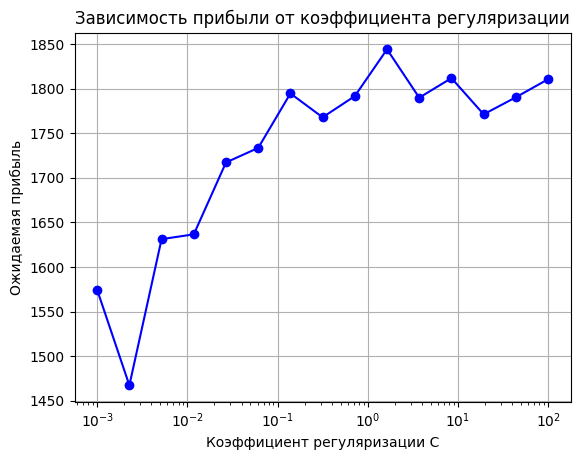

In [875]:
def profit_score(y_true, y_pred):
    return (((y_true == 1) & (y_true == y_pred)) * np.random.uniform(0, 20, size=y_true.shape)).sum() - np.sum(y_pred)

def cross_validate(X, y, n_splits=5, random_state=42, shuffle=True, optimize_C=False):
    metrics = []
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    categorical = X.select_dtypes(include=["object"]).columns
    numeric = X.select_dtypes(include=["float64", "int64"]).columns

    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(sparse_output=False, handle_unknown='ignore'), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    profit_metrics = []
    c_space = np.logspace(-3, 2, 15)

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = Pipeline(steps=[
            ('preprocessor', column_transformer),
            ('classifier', LogisticRegression(max_iter=1000))
        ])

        model.fit(X_train, y_train)
        y_pred_prob = model.predict_proba(X_test)[:, 1]
        y_pred = model.predict(X_test)

        auc_pr = average_precision_score(y_test, y_pred_prob)
        metrics.append({
            "fold": fold + 1,
            "AUC-PR": auc_pr
        })

        c_profit = profit_score(y_test, y_pred)
        profit_metrics.append(c_profit)

        print(f"Fold {fold + 1}: AUC-PR = {auc_pr:.4f}, Profit = {c_profit:.2f}")

    avg_auc_pr = np.mean([metric["AUC-PR"] for metric in metrics])
    print(f"Average AUC-PR: {avg_auc_pr:.4f}")

    if optimize_C:
        best_c = None
        best_profit = -np.inf
        for c in c_space:
            fold_profit = []
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = Pipeline(steps=[
                    ('preprocessor', column_transformer),
                    ('classifier', LogisticRegression(C=c, max_iter=1000))
                ])
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                fold_profit.append(profit_score(y_test, y_pred))

            mean_profit = np.mean(fold_profit)
            if mean_profit > best_profit:
                best_profit = mean_profit
                best_c = c

        print(f"Best C: {best_c}, Best Profit: {best_profit:.2f}")
        profit_metrics = []
        for c in c_space:
            c_profit = []
            for train_index, test_index in kf.split(X):
                X_train, X_test = X.iloc[train_index], X.iloc[test_index]
                y_train, y_test = y.iloc[train_index], y.iloc[test_index]

                model = Pipeline(steps=[
                    ('preprocessor', column_transformer),
                    ('classifier', LogisticRegression(C=c, max_iter=1000))
                ])
                model.fit(X_train, y_train)
                y_pred = model.predict(X_test)
                c_profit.append(profit_score(y_test, y_pred))

            profit_metrics.append(np.mean(c_profit))

        plt.plot(c_space, profit_metrics, marker='o', linestyle='-', color='b')
        plt.xscale('log')
        plt.xlabel('Коэффициент регуляризации C')
        plt.ylabel('Ожидаемая прибыль')
        plt.title('Зависимость прибыли от коэффициента регуляризации')
        plt.grid(True)
        plt.show()

    return pd.DataFrame(metrics)
results = cross_validate(X, y, n_splits=5, random_state=42, shuffle=True, optimize_C=True)


Попробуйте запустить перебор несколько раз. Находится ли каждый раз один и тот же "лучший" коэффициент? Присутствует ли какая-то закономерность? Какие вы можете сделать из этого выводы?

In [877]:
# your code here
def cross_validate_with_profit_repeats(X, y, n_splits=5, random_state=42, shuffle=True, repeats=5):
    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)
    encoder = OneHotEncoder(sparse_output=False)
    scaler = StandardScaler()

    categorical = X.select_dtypes(include=["object"]).columns
    numeric = X.select_dtypes(include=["number"]).columns

    X_encoded = encoder.fit_transform(X[categorical])
    X_scaled = scaler.fit_transform(X[numeric])
    X_processed = np.concatenate((X_encoded, X_scaled), axis=1)

    c_space = np.logspace(-3, 2, 15)

    def profit_score(y_true, y_pred):
        return (((y_true == 1) & (y_true == y_pred)) * np.random.uniform(0, 20, size=y_true.shape)).sum() - np.sum(y_pred)

    best_c_iters = []

    for repeat in range(repeats):
        profit_metrics = []
        for c in c_space:
            c_profit = []
            for train_fold_idx, test_fold_idx in kf.split(X_processed):
                model = LogisticRegression(C=c, max_iter=1000).fit(X_processed[train_fold_idx], y.iloc[train_fold_idx])
                y_pred = model.predict(X_processed[test_fold_idx])
                c_profit.append(profit_score(y.iloc[test_fold_idx], y_pred))
            profit_metrics.append(np.array(c_profit).mean())

        best_c = c_space[np.argmax(np.array(profit_metrics))]
        best_c_iters.append(best_c)

        print(f"Iteration {repeat + 1}: Best C = {best_c:.4f}")


best_c_values = cross_validate_with_profit_repeats(X, y, n_splits=5, random_state=42, repeats=5)


Iteration 1: Best C = 3.7276
Iteration 2: Best C = 8.4834
Iteration 3: Best C = 0.7197
Iteration 4: Best C = 43.9397
Iteration 5: Best C = 0.3162


Получились разные значения С, это может быть связано с довольно большой дисперсией

#### __Задание 13. Ключевая метрика__ (1 балл)

Выше мы уже описали примерную экономическую модель вашей задачи. Как вы считаете, что для вашего бизнеса важнее — хороший precision или recall модели? Почему?

__Ответ:__ # your answer here
Precision показывает, насколько точны наши предсказания для положительного класса, то есть из всех предсказанных положительных случаев, сколько на самом деле были верными. Максимизация precision означает минимизацию ложных положительных срабатываний, что в данной задаче может привести к меньшему числу звонков и, соответственно, затрат на сотрудников.

Однако для максимизации прибыли важнее recall, который показывает, какую долю реальных положительных случаев мы смогли предсказать. Чем выше recall, тем больше клиентов, которые действительно согласятся, мы охватим, что напрямую увеличивает наш заработок. Поэтому, в контексте задачи, где цель – заработать больше, максимизация recall имеет приоритет над precision.



> Вспомним, что на самом деле логистическая регрессия предсказывает нам вероятности положительного класса для объекта. Возможно, путем настройки __порога бинаризации__ этих вероятностей мы сможем получить какой-то выигрыш?

Проверьте ваши рассуждения выше с помощью настройки порога бинаризации на кросс-валидации для максимизации прибыли. Воспользуйтесь сеткой от 0 до 1 с шагом 0.01. Напомним, что снижение порога дает нам более высокий recall и более низкий precision, и наоборот. Добавьте новую ML-метрику в ваш CV-пайплайн, найдите такой порог, при котором бизнес-метрика максимальна, и проверьте, связана ли новая ML метрика с профитом

Добавим Recall как дополнительную ML-метрику в CV-пайплайн

In [881]:
def profit_score_tune_threshold(y_true, proba, threshold):
    y_pred = (proba > threshold).astype(int)
    return (((y_true == 1) & (y_true == y_pred)) * np.random.uniform(0, 20, size=y_true.shape)).sum() - np.sum(y_pred)

def cross_validate_with_threshold(X, y, n_splits=5, random_state=42, shuffle=True):
    metrics = []
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)

    threshold_space = np.linspace(0, 1, 100)

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = Pipeline(steps=[
            ('preprocessor', column_transformer),
            ('classifier', LogisticRegression(C=best_c, max_iter=1000))
        ])

        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]


        threshold_profit = []
        for t in threshold_space:
            threshold_profit.append(profit_score_tune_threshold(y_test, proba, threshold=t))


        best_threshold = threshold_space[np.argmax(threshold_profit)]
        best_profit = max(threshold_profit)


        y_pred = (proba > best_threshold).astype(int)
        recall = recall_score(y_test, y_pred)
        auc_pr = average_precision_score(y_test, proba)

        metrics.append({
            "fold": fold + 1,
            "Best Threshold": best_threshold,
            "Profit": best_profit,
            "Recall": recall,
            "AUC-PR": auc_pr
        })
        print(f"Fold {fold + 1}: Best Threshold = {best_threshold:.2f}, Profit = {best_profit:.2f}, Recall = {recall:.4f}, AUC-PR = {auc_pr:.4f}")

    return pd.DataFrame(metrics)

results = cross_validate_with_threshold(X, y, n_splits=5, random_state=42, shuffle=True)

average_results = results.mean()
print("\nAverage Results:")
print(average_results)

correlation_recall_profit = results["Recall"].corr(results["Profit"])
correlation_aucpr_profit = results["AUC-PR"].corr(results["Profit"])
print(f"\nCorrelation between Recall and Profit: {correlation_recall_profit:.4f}")
print(f"Correlation between AUC-PR and Profit: {correlation_aucpr_profit:.4f}")


Fold 1: Best Threshold = 0.15, Profit = 4248.34, Recall = 0.5786, AUC-PR = 0.4309
Fold 2: Best Threshold = 0.11, Profit = 4320.98, Recall = 0.6514, AUC-PR = 0.4728
Fold 3: Best Threshold = 0.12, Profit = 4535.55, Recall = 0.6254, AUC-PR = 0.4495
Fold 4: Best Threshold = 0.17, Profit = 4172.65, Recall = 0.6071, AUC-PR = 0.4552
Fold 5: Best Threshold = 0.19, Profit = 4563.55, Recall = 0.5781, AUC-PR = 0.4551

Average Results:
fold                 3.000000
Best Threshold       0.149495
Profit            4368.215122
Recall               0.608107
AUC-PR               0.452695
dtype: float64

Correlation between Recall and Profit: -0.0587
Correlation between AUC-PR and Profit: 0.1055


Корреляция между Recall и прибылью отрицательная и близка к нулю. Это может указывать на то, что увеличение Recall не всегда напрямую связано с увеличением прибыли.

Постройте график зависимости прибыли от порога бинаризации. Выделите наилучший порог




Fold 1: Best Threshold = 0.15, Profit = 4267.21, Recall = 0.5797, AUC-PR = 0.4310
Fold 2: Best Threshold = 0.09, Profit = 4454.31, Recall = 0.6928, AUC-PR = 0.4726
Fold 3: Best Threshold = 0.11, Profit = 4556.92, Recall = 0.6462, AUC-PR = 0.4498
Fold 4: Best Threshold = 0.16, Profit = 4241.38, Recall = 0.6150, AUC-PR = 0.4552
Fold 5: Best Threshold = 0.10, Profit = 4470.08, Recall = 0.6530, AUC-PR = 0.4553


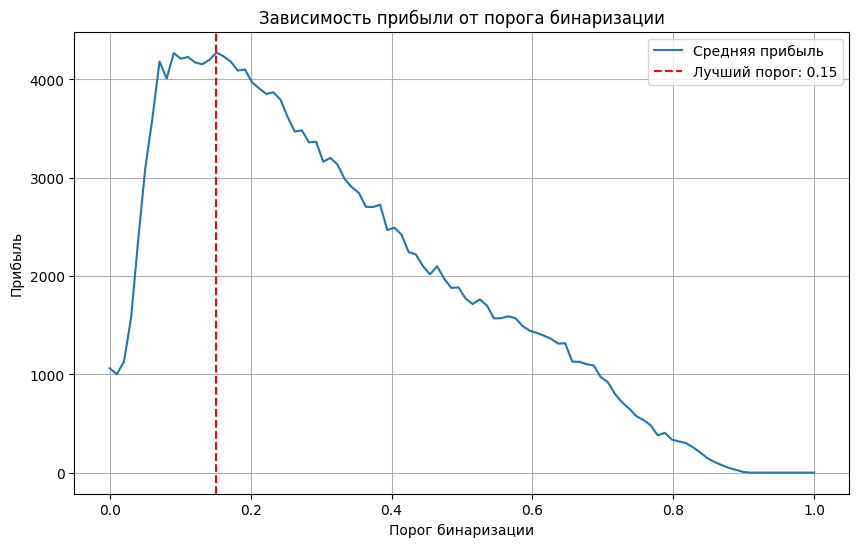

In [887]:
# your code here
def profit_score_tune_threshold(y_true, proba, threshold):
    y_pred = (proba > threshold).astype(int)
    return (((y_true == 1) & (y_true == y_pred)) * np.random.uniform(0, 20, size=y_true.shape)).sum() - np.sum(y_pred)
def cross_validate_with_threshold(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True):
    metrics = []
    column_transformer = ColumnTransformer([
        ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
        ('scaling', StandardScaler(), numeric)
    ])

    kf = KFold(n_splits=n_splits, random_state=random_state, shuffle=shuffle)


    threshold_space = np.linspace(0, 1, 100)

    best_c = 3.7276

    all_threshold_profit = []

    for fold, (train_index, test_index) in enumerate(kf.split(X)):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        model = Pipeline(steps=[
            ('preprocessor', column_transformer),
            ('classifier', LogisticRegression(C=best_c, max_iter=1000))
        ])

        model.fit(X_train, y_train)
        proba = model.predict_proba(X_test)[:, 1]


        threshold_profit = []
        for t in threshold_space:
            threshold_profit.append(profit_score_tune_threshold(y_test, proba, threshold=t))


        best_threshold = threshold_space[np.argmax(threshold_profit)]
        best_profit = max(threshold_profit)

        y_pred = (proba > best_threshold).astype(int)

        recall = recall_score(y_test, y_pred)
        auc_pr = average_precision_score(y_test, proba)

        metrics.append({
            "fold": fold + 1,
            "Best Threshold": best_threshold,
            "Profit": best_profit,
            "Recall": recall,
            "AUC-PR": auc_pr
        })

        print(f"Fold {fold + 1}: Best Threshold = {best_threshold:.2f}, Profit = {best_profit:.2f}, Recall = {recall:.4f}, AUC-PR = {auc_pr:.4f}")

        all_threshold_profit.append(threshold_profit)

    results_df = pd.DataFrame(metrics)

    avg_profit = np.mean(all_threshold_profit, axis=0)

    plt.figure(figsize=(10, 6))
    plt.plot(threshold_space, avg_profit, label='Средняя прибыль')
    plt.xlabel('Порог бинаризации')
    plt.ylabel('Прибыль')
    plt.title('Зависимость прибыли от порога бинаризации')
    plt.axvline(x=threshold_space[np.argmax(avg_profit)], color='r', linestyle='--', label=f'Лучший порог: {threshold_space[np.argmax(avg_profit)]:.2f}')
    plt.legend()
    plt.grid(True)
    plt.show()

    return results_df

results = cross_validate_with_threshold(X, y, categorical, numeric, n_splits=5, random_state=42, shuffle=True)



__Вопрос:__ Замечаете ли вы какую-то закономерность? Для правильного ответа на этот вопрос попробуйте запустить несколько раз и задумайтесь, почему порог получается в какой-то конкретной области?

__Ответ:__ # your answer here
Порог около 0.15 позволяет модели звонить достаточно клиентам, чтобы получить прибыль, но не так много, чтобы сильно увеличить затраты на ложные звонки. Это оптимизирует прибыль, минимизируя расходы.

Наконец, чтобы точнее понять, что наша модель лучше исходной, посчитайте среднее и стандартное отклонение по фолдам бизнес-метрики для оптимизированной модели (гиперпараметры + порог) и дефолтной логистической регрессии. Проверьте, действительно ли удалось добиться значимого изменения прибыли — примените какой-либо статистический тест (например, парный t-критерий с $\alpha=0.95$) к метрике, полученной двумя этими моделями

In [ ]:
# your code here

# __Бонусная часть. Многоклассовая классификация__ (1.5 балла)

Как известно, некоторые задачи не ограничиваются всего лишь двумя классами. На лекции вы проходили несколько способов обобщения линейных моделей на этот случай: One-vs-Rest и One-vs-One. Ниже мы посмотрим, в чём преимущества и недостатки обоих подходов, а так же попробуем ещё один чуть более экзотический метод

#### **Задание 14. One-vs-Rest vs One-vs-One** (0.5 балла)

В качестве [датасета](https://www.kaggle.com/datasets/thedevastator/higher-education-predictors-of-student-retention/data) здесь и ниже мы будем брать очень жизненные и актуальные данные о том, доучится студент или нет, в зависимости от курсов, возраста, гендера и прочих (не)осуждаемых признаков.

In [ ]:
import kagglehub

path = kagglehub.dataset_download("thedevastator/higher-education-predictors-of-student-retention") + "/dataset.csv"

features = ["Marital status", "Course", "Nacionality", "Gender", "Age at enrollment"]
target = "Target"

Будем смотреть только какое-то подмножество наиболее весёлых факторов. От вас по классике потребуется их преобразовать, в зависимости от того, числовые они или категориальные и **закодировать таргет чиселками!!!**

In [ ]:
# your code here

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=228, shuffle=True, test_size=0.2)

Ваш следующий шаг - посмотреть, каким образом в `sklearn` реализованы OvR и OvO, обучить таким образом логистическую регрессию с `max_iter=10000`, далее выбрать какую-то метрику (и её усреднение, его выбор тоже аргументируйте), и сравнить следующие параметры:
- число классификаторов
- скорость обучения
- качество модели

Также сохраните куда-нибудь предсказания вероятностей у каждой из моделей. Это можно сделать не одним способом, но возможно вам чуть с этим поможет следующий пункт


In [ ]:
# your code here

Как вы объясните полученные результаты?

__Ответ:__ # your code here

#### __Задание 15. Softmax регрессия__ (1 балл)

Однако любознательные машинисты могут задаться вопросом "А зачем нам вся эта шляпа, если у сигмоиды есть обобщение на случай многоклассовой классификации?" Если вам понравилось считать градиенты в прошлом дз, или вам нравится обучать нейросети, этот пункт для вас. Здесь мы попробуем построить одну-единственную модель, которая будет всё предсказывать, а также сравним с вариантами выше

Начнём с подсчёта лосса. Вспомним, что логистическая функция потерь это частный случай кросс-энтропии, её и будем пытаться оптимизировать.

$$
\text{CE}(X, y) = -\frac{1}{N}\sum_i \sum_k [y_i = k] \log p(x_i = k)
$$
Вероятности в данном случае будем считать при помощи софтмакса, что есть общий случай сигмоиды

$$
p(x_i) = \text{Softmax}(a(x_i)); \quad
\text{Softmax}(x)_k = \frac{e^{x_{k}}}{\sum_j e^{x_{j}}} \\
$$

Предсказание модели на одном объекта будет делаться уже при помощи матрицы весов, посклоьку выходов несколько

$$
a(x_i) = x_i\cdot W \\
$$

Ниже предлагается написать код для такой функции потерь. Если необходимо, модифицируйте шаблон по своему усмотрению (вспомогательные функции, новые аргументы, всё, что душа пожелает)

In [ ]:
from typing import Iterable, Optional
from torch.nn.functional import cross_entropy
import torch

def custom_ce(
    y_pred: np.ndarray[float],
    y_true: np.ndarray[int],
) -> float:
    # your code here
    return

In [ ]:
for _ in range(1000):

    n_objects = np.random.randint(1, 100)
    n_classes = np.random.randint(2, 20)
    y_pred = np.random.normal(0, 1, (n_objects, n_classes))
    y_true = np.random.randint(low=0, high=n_classes, size=(n_objects,))

    your_ce = custom_ce(y_pred, y_true) # не забудьте поправить, если меняли шаблон
    torch_ce = cross_entropy(torch.tensor(y_pred), torch.tensor(y_true))
    assert np.allclose(your_ce, torch_ce), "Что-то пошло не так"

Дальше самая интересная часть - нужно вывести производную этой функции потерь (на всякий случай уточним, что `torch` использовать нельзя, разве что для самопроверки). Полезные факты, которые вам могут пригодиться:

- в матричном виде найти производную непросто, попробуйте сперва сделать это для одного объекта, обобщить будет полегче
- логсофтмакс дифференцировать гораздо легче, чем просто софтмакс
- не забывайте про правило дифференцирования сложной функции
- поскольку веса в данном случае матрица, результат будет тоже матрица, учтите при сверке размерностей
- если вы не придумали, как преобразовать индикаторы в векторный вид, сейчас самое время

In [ ]:
def ce_gradient(X: np.ndarray, W: np.ndarray, y: np.ndarray) -> np.ndarray[float]:
    # your code here
    return

Дальше дело за малым. Вспомните (или узнайте), как делается градиентный спуск, и дополните класс софтмакс-регрессии ниже. Здесь разумнее использовать критерий останова по итерациям, но логрег из `sklearn` устроен немного хитрее. Если хотите добавить еще критерии останова, какие-то другие параметры, то пожалуйста

In [ ]:
class SoftmaxRegression:

    def __init__(self, lr=1e-3, max_iter=10000):
        self.W = None
        self.max_iter = max_iter
        self.lr = lr

    def fit(self, X, y):
        # your code here

    def predict(self, X, y=None):
        # your code here

Обучите на тех же данных, что и выше, замерьте те же три параметра, плюс сравните значения кросс-энтропии для уже трёх моделей. Сравните модели между собой и выберите фаворита в данной задаче.

In [ ]:
# your code here

__Ответ__: # your text here

__Бонус (0.01 балла):__ что вы кушали в день сдачи данного ДЗ на завтрак?

__Ответ:__ # your answer here
омлет с помидорами